# Phân tích dữ liệu


## Install thư viện

In [358]:
# %pip install matplotlib pandas numpy seaborn wordcloud underthesea facebook-scraper transformers torch

In [359]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import underthesea as nlp
import datetime, re, json
import requests

## Khám phá tập dữ liệu

In [360]:
raw_gam_df = pd.read_csv('Data/GAMeSportsVN.csv')


In [361]:
raw_gam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   post_id                        250 non-null    int64  
 1   text                           246 non-null    object 
 2   post_text                      246 non-null    object 
 3   shared_text                    7 non-null      object 
 4   original_text                  13 non-null     object 
 5   time                           250 non-null    object 
 6   timestamp                      250 non-null    int64  
 7   image                          172 non-null    object 
 8   image_lowquality               250 non-null    object 
 9   images                         250 non-null    object 
 10  images_description             250 non-null    object 
 11  images_lowquality              250 non-null    object 
 12  images_lowquality_description  250 non-null    obj

## Làm sạch dữ liệu

### Xóa bỏ những cột không cần thiết hoặc miss dữ liệu toàn bộ

In [362]:
# raw_gam_df.drop(['video_duration_seconds','original_text', 'video_height', 'video_quality', 'video_size_MB', 'video_watches', 'video_width', 'factcheck', 'fetched_time', 'shared_text', 'video_thumbnail', 'image_lowquality', ], axis= 'columns', inplace = True)
# raw_gam_df.head(5)

raw_gam_df = raw_gam_df[["post_id", "post_text", "time", "timestamp", "image", "video", "comments", "shares","comments_full", "reactions" , "reaction_count"]].copy()
raw_gam_df.head(3)

post_id                                          post_text  \
0  737976521702400  Palette: Góc đẹp, nhìn em mở nè anh em! 😎 #GAM...   
1  737919055041480  Cái gì quan trọng thì mình nhắc lại 42 lần! 🙄 ...   
2  737886838378035  Tâm linh không đùa được đâu! 🫣\n\nXem thêm ở M...   

                  time   timestamp image  \
0  2023-11-07 19:46:57  1699361217   NaN   
1  2023-11-07 17:19:53  1699352393   NaN   
2  2023-11-07 15:43:23  1699346603   NaN   

                                               video  comments  shares  \
0  https://scontent.fhan5-11.fna.fbcdn.net/v/t42....         9       0   
1  https://scontent.fhan5-8.fna.fbcdn.net/v/t42.1...        70       1   
2  https://scontent.fhan5-8.fna.fbcdn.net/v/t42.1...        12       6   

                                       comments_full  \
0  [{'comment_id': '687445613484826', 'comment_ur...   
1  [{'comment_id': '1060101512081817', 'comment_u...   
2  [{'comment_id': '300064389519874', 'comment_ur...   

                                           reactions  reaction_count  
0                          {'thích': 223, 'haha': 3}             226  
1  {'thích': 243, 'yêu thích': 3, 'haha': 74, 'bu...             321  
2  {'thích': 761, 'yêu thích': 5, 'haha': 304, 't...            1079

### Phân tách, đồng bộ dữ liệu của các cột

Giới hạn dữ liệu trong vòng 1 tháng từ 8 - 10 - 2023 đến 7 - 11 - 2023, phân tách dữ liệu thời gian phục vụ cho phân tích

In [363]:

def limit_data(raw_df) : 
    raw_df['time'] = pd.to_datetime(raw_df['time'])
    raw_df = raw_df[(raw_df['time'] > '2023-10-8 20:00:00') & (raw_df['time'] < '2023-11-9')]
    raw_df['date'] = raw_df['time'].dt.date
    raw_df['time_hour'] = raw_df['time'].dt.hour
    raw_df['date_time'] =  raw_df['time']
    raw_df['time'] = raw_df['time'].dt.time
    return raw_df

raw_gam_df = limit_data(raw_gam_df)


C:\Users\Asus\AppData\Local\Temp\ipykernel_7100\2703664253.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['date'] = raw_df['time'].dt.date
C:\Users\Asus\AppData\Local\Temp\ipykernel_7100\2703664253.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['time_hour'] = raw_df['time'].dt.hour
C:\Users\Asus\AppData\Local\Temp\ipykernel_7100\2703664253.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [364]:
raw_gam_df[raw_gam_df['time_hour'] == 7]

post_id                                          post_text  \
142  724154089751310  Đưa thương hiệu Việt ra thế giới! 🔥\n\n#GAMTIM...   
143  724136833086369  [GAM DAY]\n\nGAM và TW, 2 đại diện của VCS sẽ ...   

         time   timestamp                                              image  \
142  07:42:59  1697330579  https://scontent.fhan5-8.fna.fbcdn.net/v/t39.3...   
143  07:08:03  1697328483  https://scontent.fhan5-8.fna.fbcdn.net/v/t39.3...   

    video  comments  shares  \
142   NaN        83      29   
143   NaN       214      11   

                                         comments_full  \
142  [{'comment_id': '863716351658714', 'comment_ur...   
143  [{'comment_id': '352734020562699', 'comment_ur...   

                                             reactions  reaction_count  \
142  {'thích': 7033, 'yêu thích': 132, 'haha': 2490...            9717   
143  {'thích': 2288, 'yêu thích': 292, 'haha': 22, ...            2621   

           date  time_hour           date_time  
142  2023-10-15          7 2023-10-15 07:42:59  
143  2023-10-15          7 2023-10-15 07:08:03

In [365]:
raw_gam_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197 entries, 0 to 196
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   post_id         197 non-null    int64         
 1   post_text       197 non-null    object        
 2   time            197 non-null    object        
 3   timestamp       197 non-null    int64         
 4   image           140 non-null    object        
 5   video           50 non-null     object        
 6   comments        197 non-null    int64         
 7   shares          197 non-null    int64         
 8   comments_full   197 non-null    object        
 9   reactions       197 non-null    object        
 10  reaction_count  197 non-null    int64         
 11  date            197 non-null    object        
 12  time_hour       197 non-null    int32         
 13  date_time       197 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int32(1), int64(5), object(7)
memory usag

Tách dữ liệu reaction thành các cột

In [366]:
def separate_reaction(raw_df) : 
    raw_df['reactions'] = raw_df['reactions'].apply(lambda x : dict(eval(str(x))))
    raw_reaction = raw_df['reactions'].apply(pd.Series)
    raw_reaction = raw_reaction.fillna(0)
    return raw_reaction

raw_reac_gam_df = separate_reaction(raw_gam_df)




C:\Users\Asus\AppData\Local\Temp\ipykernel_7100\1099072365.py:3: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  raw_reaction = raw_df['reactions'].apply(pd.Series)


In [367]:
main_data = pd.concat([raw_gam_df, raw_reac_gam_df], axis = 1).drop('reactions', axis = 1)

main_data.head(5)


post_id                                          post_text  \
0  737976521702400  Palette: Góc đẹp, nhìn em mở nè anh em! 😎 #GAM...   
1  737919055041480  Cái gì quan trọng thì mình nhắc lại 42 lần! 🙄 ...   
2  737886838378035  Tâm linh không đùa được đâu! 🫣\n\nXem thêm ở M...   
3  737500015083384  Palette tung là anh em vào hứng ngay! 🥳 #GAMTI...   
4  737427961757256  Khởi đầu cho các cuộc nội chiến tại CKTG, GAM ...   

       time   timestamp image  \
0  19:46:57  1699361217   NaN   
1  17:19:53  1699352393   NaN   
2  15:43:23  1699346603   NaN   
3  20:44:33  1699278273   NaN   
4  17:58:59  1699268339   NaN   

                                               video  comments  shares  \
0  https://scontent.fhan5-11.fna.fbcdn.net/v/t42....         9       0   
1  https://scontent.fhan5-8.fna.fbcdn.net/v/t42.1...        70       1   
2  https://scontent.fhan5-8.fna.fbcdn.net/v/t42.1...        12       6   
3  https://scontent.fhan5-8.fna.fbcdn.net/v/t42.1...       128       5   
4  https://scontent.fhan5-2.fna.fbcdn.net/v/t42.1...        46       0   

                                       comments_full  reaction_count  \
0  [{'comment_id': '687445613484826', 'comment_ur...             226   
1  [{'comment_id': '1060101512081817', 'comment_u...             321   
2  [{'comment_id': '300064389519874', 'comment_ur...            1079   
3  [{'comment_id': '312106058277547', 'comment_ur...             970   
4  [{'comment_id': '839663224521349', 'comment_ur...             987   

         date  time_hour           date_time  thích   haha  yêu thích  buồn  \
0  2023-11-07         19 2023-11-07 19:46:57  223.0    3.0        0.0   0.0   
1  2023-11-07         17 2023-11-07 17:19:53  243.0   74.0        3.0   1.0   
2  2023-11-07         15 2023-11-07 15:43:23  761.0  304.0        5.0   7.0   
3  2023-11-06         20 2023-11-06 20:44:33  949.0    5.0       15.0   1.0   
4  2023-11-06         17 2023-11-06 17:58:59  878.0   16.0       90.0   0.0   

   thương thương  wow  phẫn nộ  
0            0.0  0.0      0.0  
1            0.0  0.0      0.0  
2            2.0  0.0      0.0  
3            0.0  0.0      0.0  
4            2.0  1.0      0.0

In [368]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197 entries, 0 to 196
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   post_id         197 non-null    int64         
 1   post_text       197 non-null    object        
 2   time            197 non-null    object        
 3   timestamp       197 non-null    int64         
 4   image           140 non-null    object        
 5   video           50 non-null     object        
 6   comments        197 non-null    int64         
 7   shares          197 non-null    int64         
 8   comments_full   197 non-null    object        
 9   reaction_count  197 non-null    int64         
 10  date            197 non-null    object        
 11  time_hour       197 non-null    int32         
 12  date_time       197 non-null    datetime64[ns]
 13  thích           197 non-null    float64       
 14  haha            197 non-null    float64       
 15  yêu thích  

In [369]:
main_data.drop_duplicates(inplace= True)
main_data['date'] = pd.to_datetime(main_data['date'])
main_data['video'] = ~main_data.loc[:,'video'].isna()
main_data['image'] = ~main_data.loc[:,'image'].isna()
main_data.head()

post_id                                          post_text  \
0  737976521702400  Palette: Góc đẹp, nhìn em mở nè anh em! 😎 #GAM...   
1  737919055041480  Cái gì quan trọng thì mình nhắc lại 42 lần! 🙄 ...   
2  737886838378035  Tâm linh không đùa được đâu! 🫣\n\nXem thêm ở M...   
3  737500015083384  Palette tung là anh em vào hứng ngay! 🥳 #GAMTI...   
4  737427961757256  Khởi đầu cho các cuộc nội chiến tại CKTG, GAM ...   

       time   timestamp  image  video  comments  shares  \
0  19:46:57  1699361217  False   True         9       0   
1  17:19:53  1699352393  False   True        70       1   
2  15:43:23  1699346603  False   True        12       6   
3  20:44:33  1699278273  False   True       128       5   
4  17:58:59  1699268339  False   True        46       0   

                                       comments_full  reaction_count  \
0  [{'comment_id': '687445613484826', 'comment_ur...             226   
1  [{'comment_id': '1060101512081817', 'comment_u...             321   
2  [{'comment_id': '300064389519874', 'comment_ur...            1079   
3  [{'comment_id': '312106058277547', 'comment_ur...             970   
4  [{'comment_id': '839663224521349', 'comment_ur...             987   

        date  time_hour           date_time  thích   haha  yêu thích  buồn  \
0 2023-11-07         19 2023-11-07 19:46:57  223.0    3.0        0.0   0.0   
1 2023-11-07         17 2023-11-07 17:19:53  243.0   74.0        3.0   1.0   
2 2023-11-07         15 2023-11-07 15:43:23  761.0  304.0        5.0   7.0   
3 2023-11-06         20 2023-11-06 20:44:33  949.0    5.0       15.0   1.0   
4 2023-11-06         17 2023-11-06 17:58:59  878.0   16.0       90.0   0.0   

   thương thương  wow  phẫn nộ  
0            0.0  0.0      0.0  
1            0.0  0.0      0.0  
2            2.0  0.0      0.0  
3            0.0  0.0      0.0  
4            2.0  1.0      0.0

In [370]:
## Bài đăng có lượng tương tác cao nhất : 
main_data.sort_values("yêu thích", ascending = False).head(1)

post_id                                          post_text  \
126  724455726387813  Cảm xúc nghẹn ngào của anh TK Nguyễn sau màn t...   

         time   timestamp  image  video  comments  shares  \
126  16:06:17  1697360777  False   True       281      60   

                                         comments_full  reaction_count  \
126  [{'comment_id': '3113983895563804', 'comment_u...           16100   

          date  time_hour           date_time    thích  haha  yêu thích  buồn  \
126 2023-10-15         16 2023-10-15 16:06:17  13012.0  57.0     2911.0  16.0   

     thương thương  wow  phẫn nộ  
126           98.0  6.0      0.0

## Thói quen đăng bài của page

### Tuần suất bài đăng

In [371]:
# Số lượng bài đăng Page chính trong 1 tháng 
print("Số lượng bài đăng page Gam trong 1 tháng là: " + str(len(main_data)))

# Số bài đăng của Page / ngày
print("Trung bình số bài đăng của page Gam trên 1 ngày là: " + str(len(main_data) / 30))


Số lượng bài đăng page Gam trong 1 tháng là: 197
Trung bình số bài đăng của page Gam trên 1 ngày là: 6.566666666666666


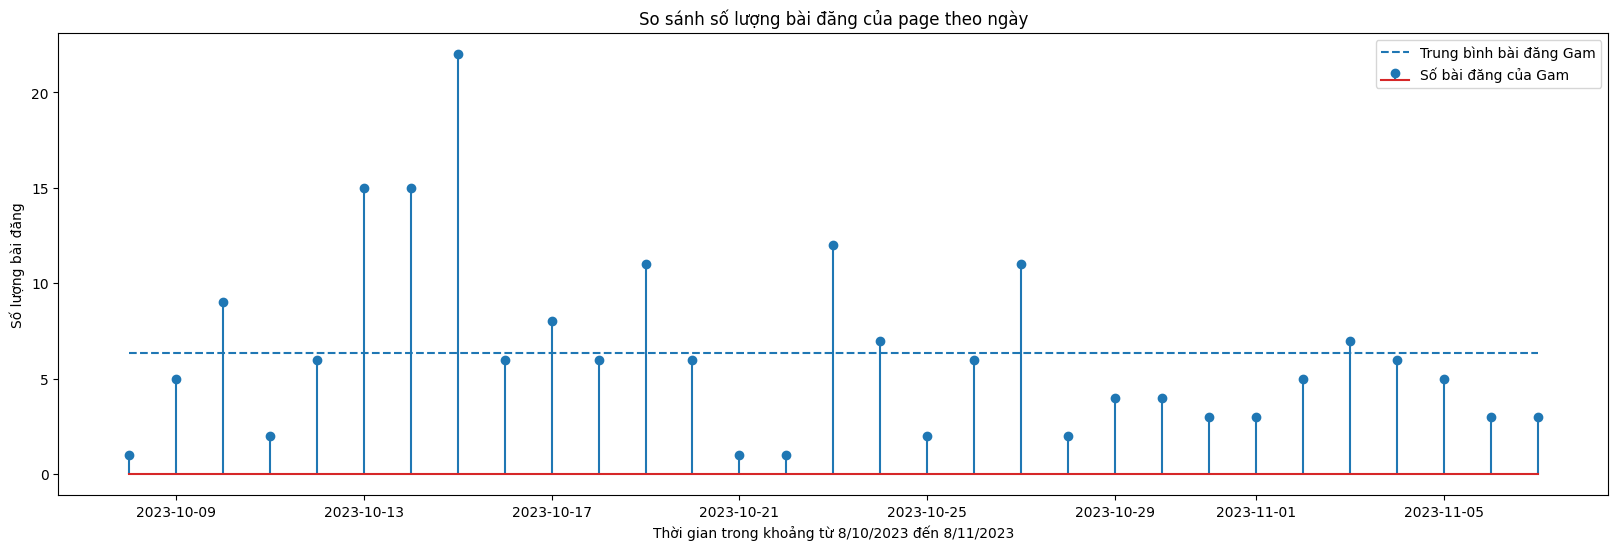

In [372]:
# Số lượng bài đăng theo các ngày trong 1 tháng của 2 đội

total_post_per_day_main = main_data['post_id'].groupby(main_data['date']).count()


mean_total_post_main = pd.Series([total_post_per_day_main.mean()] * len(total_post_per_day_main), index = total_post_per_day_main.index)


fig, ax = plt.subplots(figsize = (20,6))


ax.stem(total_post_per_day_main.index, total_post_per_day_main, label = "Số bài đăng của Gam")
ax.plot(mean_total_post_main, linestyle = '--', label = "Trung bình bài đăng Gam")

ax.set_xlabel("Thời gian trong khoảng từ 8/10/2023 đến 8/11/2023")
ax.set_ylabel("Số lượng bài đăng")
ax.legend()


ax.set_title("So sánh số lượng bài đăng của page theo ngày")
plt.show()

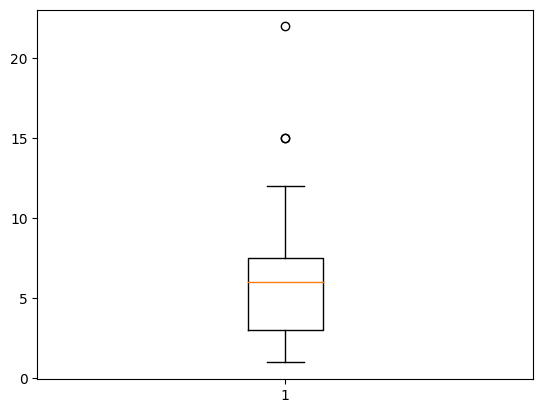

In [373]:
fig, ax = plt.subplots()

ax.boxplot(total_post_per_day_main)

plt.show()

- Một số nhận xét : 
    - Khoảng thời gian từ 13 -> 17 / 10 tăng rất lớn 
    - Khoảng 10 -> 13 / 10 + 21 -> 22/ 10 giảm sâu

### Tổ chức dữ liệu phân tích tương tác bài viết

In [374]:
reac_with_time_main = main_data[[ 'date_time', 'date', 'time_hour', 'thích', 'haha', 'yêu thích', 'buồn', 'thương thương', 'wow', 'phẫn nộ', 'shares', 'comments', 'reaction_count', 'time']]
reac_with_time_main['Total_Reac'] = reac_with_time_main['reaction_count'] + reac_with_time_main['comments'] + reac_with_time_main['shares']
reac_with_time_main.head(3)


C:\Users\Asus\AppData\Local\Temp\ipykernel_7100\3910907426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reac_with_time_main['Total_Reac'] = reac_with_time_main['reaction_count'] + reac_with_time_main['comments'] + reac_with_time_main['shares']


date_time       date  time_hour  thích   haha  yêu thích  buồn  \
0 2023-11-07 19:46:57 2023-11-07         19  223.0    3.0        0.0   0.0   
1 2023-11-07 17:19:53 2023-11-07         17  243.0   74.0        3.0   1.0   
2 2023-11-07 15:43:23 2023-11-07         15  761.0  304.0        5.0   7.0   

   thương thương  wow  phẫn nộ  shares  comments  reaction_count      time  \
0            0.0  0.0      0.0       0         9             226  19:46:57   
1            0.0  0.0      0.0       1        70             321  17:19:53   
2            2.0  0.0      0.0       6        12            1079  15:43:23   

   Total_Reac  
0         235  
1         392  
2        1097

### Tổng số bài đăng theo thời gian trong ngày

C:\Users\Asus\AppData\Local\Temp\ipykernel_7100\836363348.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  reac_with_time_main['time'] = pd.to_datetime(reac_with_time_main['time'].astype(str))
C:\Users\Asus\AppData\Local\Temp\ipykernel_7100\836363348.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reac_with_time_main['time'] = pd.to_datetime(reac_with_time_main['time'].astype(str))


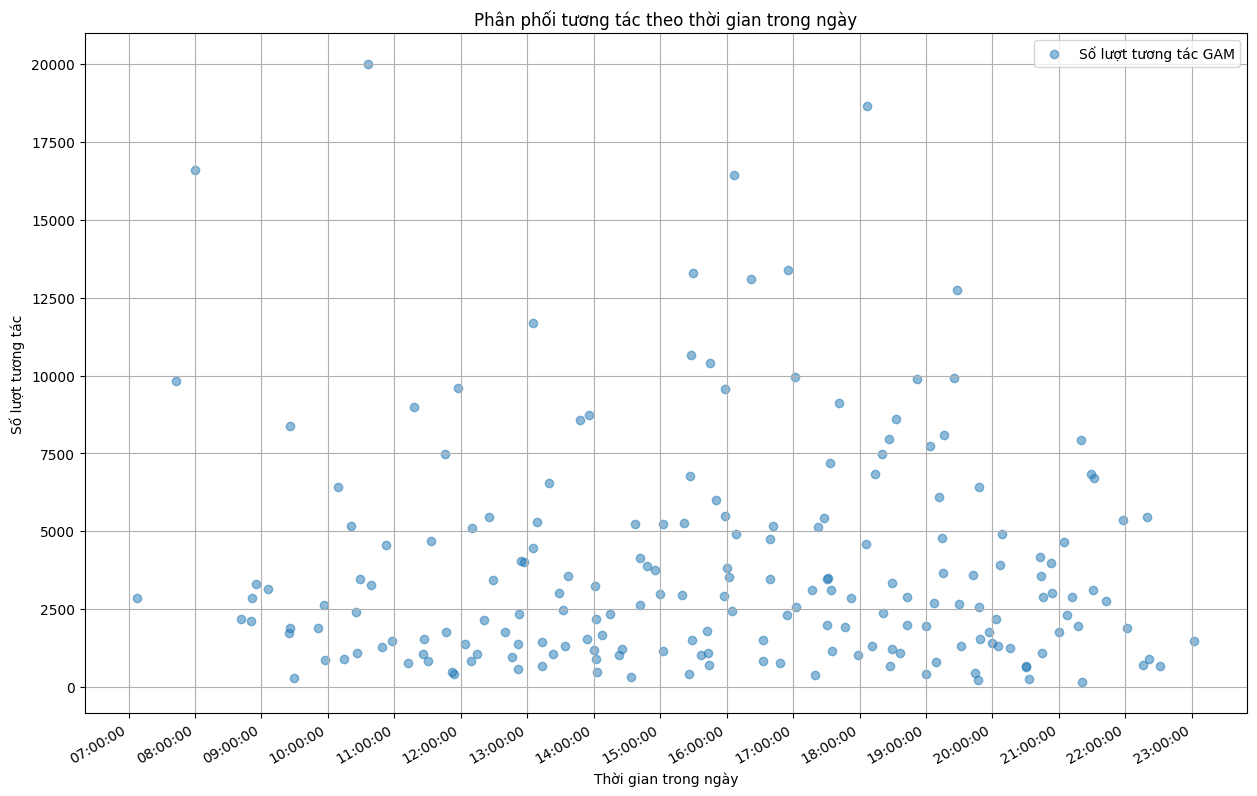

In [375]:
import matplotlib.dates as mdates


reac_with_time_main['time'] = pd.to_datetime(reac_with_time_main['time'].astype(str))

plt.figure(figsize=(15, 10))

plt.scatter(reac_with_time_main['time'], reac_with_time_main['Total_Reac'], label="Số lượt tương tác GAM", alpha=0.5)

plt.xlabel("Thời gian trong ngày")
plt.ylabel("Số lượt tương tác")
plt.title("Phân phối tương tác theo thời gian trong ngày")
plt.legend()


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  

plt.gcf().autofmt_xdate()  
plt.grid(True)

plt.show()



In [376]:
main_data[main_data['time_hour'] == 7]

post_id                                          post_text  \
142  724154089751310  Đưa thương hiệu Việt ra thế giới! 🔥\n\n#GAMTIM...   
143  724136833086369  [GAM DAY]\n\nGAM và TW, 2 đại diện của VCS sẽ ...   

         time   timestamp  image  video  comments  shares  \
142  07:42:59  1697330579   True  False        83      29   
143  07:08:03  1697328483   True  False       214      11   

                                         comments_full  reaction_count  \
142  [{'comment_id': '863716351658714', 'comment_ur...            9717   
143  [{'comment_id': '352734020562699', 'comment_ur...            2621   

          date  time_hour           date_time   thích    haha  yêu thích  \
142 2023-10-15          7 2023-10-15 07:42:59  7033.0  2490.0      132.0   
143 2023-10-15          7 2023-10-15 07:08:03  2288.0    22.0      292.0   

     buồn  thương thương  wow  phẫn nộ  
142  32.0           21.0  9.0      0.0  
143   1.0           16.0  2.0      0.0

### Tương quan tương tác từng ngày trong tháng

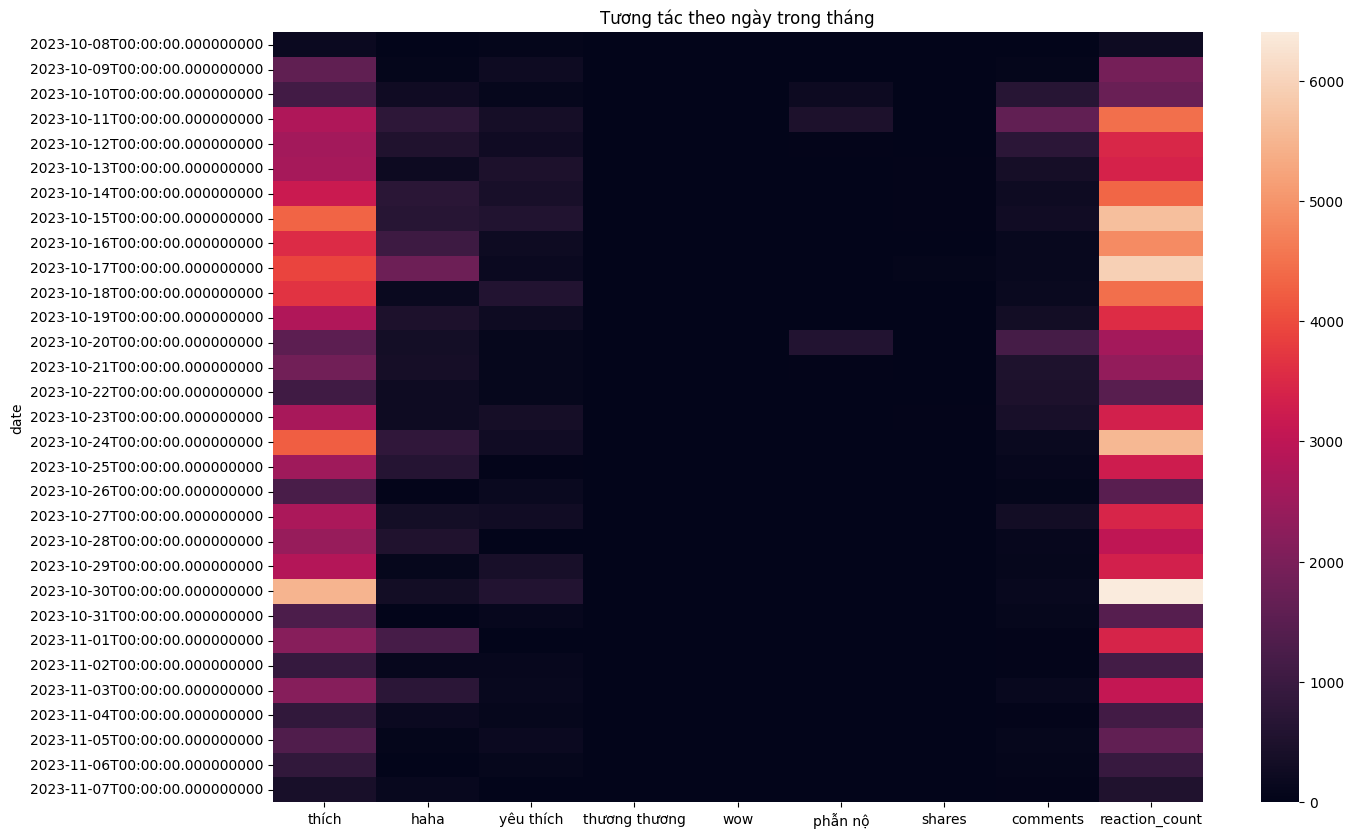

In [377]:
total_reac_per_day_main = reac_with_time_main.groupby(reac_with_time_main['date'])[['thích', 'haha', 'yêu thích', 'thương thương', 'wow', 'phẫn nộ', 'shares', 'comments', 'reaction_count']].mean()

plt.figure(figsize=(15, 10))
hm = sns.heatmap(data = total_reac_per_day_main)
hm.set_title("Tương tác theo ngày trong tháng")
plt.yticks(rotation=0)
plt.show()

- Nhận xét : 
    - Trung bình vào ngày 30 - 10 có lượng trung bình cao hơn các ngày còn lại 
    - Lượng phẫn nộ tăng vào hai ngày 11 - 10 và 20 - 10 kéo theo đó lượng bình luận cũng tăng theo

### Số bài viết dựa vào thứ trong tuần

C:\Users\Asus\AppData\Local\Temp\ipykernel_7100\1775895842.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reac_with_time['weekday'] = pd.to_datetime(reac_with_time['date']).dt.weekday
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


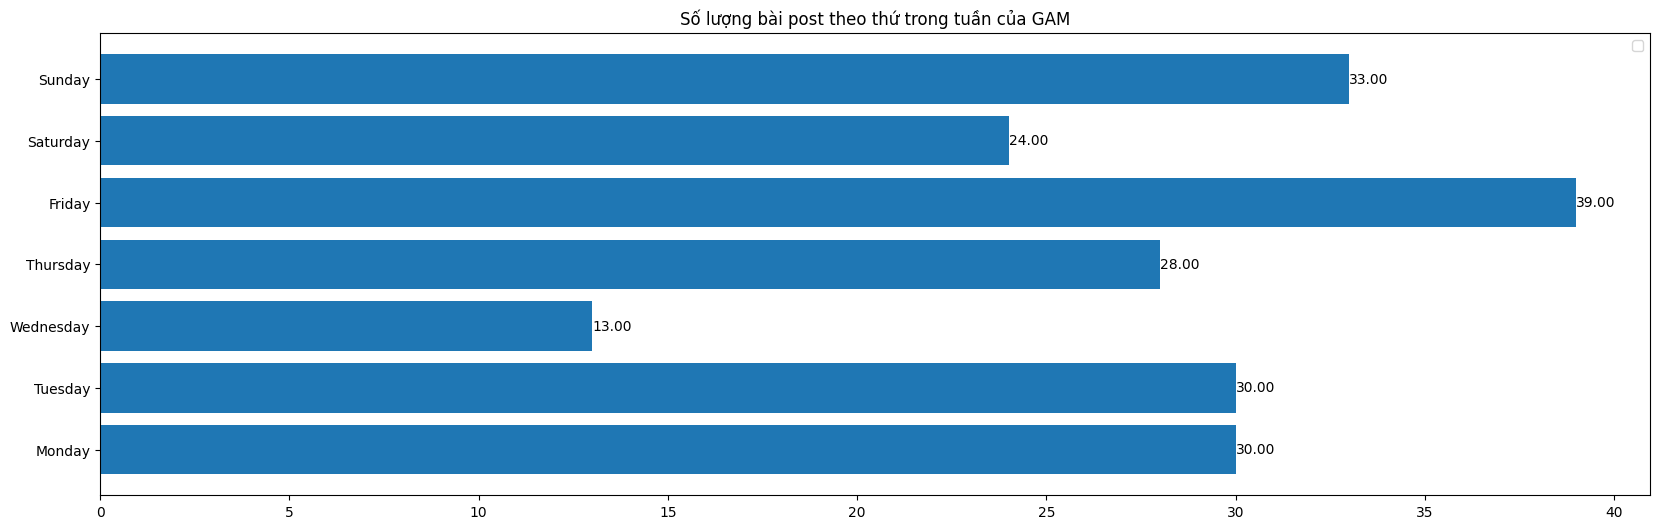

In [378]:
def find_weekday(reac_with_time) :
    reac_with_time['weekday'] = pd.to_datetime(reac_with_time['date']).dt.weekday
    mean_per_weekday = reac_with_time.groupby(reac_with_time['weekday'])['Total_Reac'].count()
    mean_per_weekday.index= ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    
    return mean_per_weekday

mean_reac_per_weekday_main = find_weekday(reac_with_time_main)

fig, ax = plt.subplots(figsize= (20,6))

X_ax = np.arange(7)
hbars = ax.barh(X_ax, mean_reac_per_weekday_main.values, align='center')
ax.bar_label(hbars, fmt='%.2f')

ax.set_yticks(X_ax, mean_reac_per_weekday_main.index)

ax.set_title("Số lượng bài post theo thứ trong tuần của GAM")
ax.legend()

plt.show()

- Note : 
    - Ngày thứ 7 tương tác ít hơn so với thứ 6 vào chủ nhật => Xem nội dung bài viết vào ngày thứ 7
    - Hai page phân bố tương tác theo số bài đăng tương tự nhau, bài đăng tăng kéo theo tương tác tăng
    - Tại sao thứ 5 hoặc 6 thường có nhiều bài đăng hơn

### Số lượng bài đăng vào những ngày đội tuyển thi đấu

In [379]:
# Ngày thi đấu giờ và kết quả 
day_of_match = {
    "date" : [datetime.datetime(2023, 10, 27), datetime.datetime(2023, 10, 23), datetime.datetime(2023, 10, 20), datetime.datetime(2023, 10, 19), datetime.datetime(2023, 10, 15), datetime.datetime(2023, 10, 14), datetime.datetime(2023, 10, 13), datetime.datetime(2023, 10, 10)], 
    "result" : [0, 1, 0, 0, 1, 1, 1, 0], 
    "time" : [14, 14, 15, 14, 10, 14, 14, 17]
}

day_of_match_df = pd.DataFrame(day_of_match)
day_of_match_df = day_of_match_df.sort_values("date",ascending= True)
tmp = pd.to_datetime(day_of_match_df['date']) + pd.to_timedelta(day_of_match_df['time'], unit='h')
list_of_bound_time = tmp.to_list()


In [380]:
day_of_match_df_union = pd.merge(day_of_match_df, main_data, left_on = "date", right_on = "date", how = 'left')
total_after =   day_of_match_df_union[day_of_match_df_union['time_hour'] > day_of_match_df_union['time_x']].groupby(day_of_match_df_union["date"])['date'].count()
total_before = day_of_match_df_union[day_of_match_df_union['time_hour'] <= day_of_match_df_union['time_x']].groupby(day_of_match_df_union["date"])['date'].count()
day_of_match_df = pd.merge(day_of_match_df, total_after, left_on = "date", right_index= True, how = "left")
day_of_match_df = pd.merge(day_of_match_df, total_before, left_on= "date_x", right_index= True, suffixes=('_df1', '_df2'))
# day_of_match_df.drop(["date_df1", "date_x"], axis= True, inplace= True)
day_of_match_df.columns = ['date', 'result', 'time', 'total_after', 'total_before']
day_of_match_df.fillna(0, inplace= True)

day_of_match_df

date  result  time  total_after  total_before
7 2023-10-10       0    17          0.0             9
6 2023-10-13       1    14          9.0             6
5 2023-10-14       1    14          8.0             7
4 2023-10-15       1    10         15.0             7
3 2023-10-19       0    14          5.0             6
2 2023-10-20       0    15          1.0             5
1 2023-10-23       1    14          8.0             4
0 2023-10-27       0    14          2.0             9

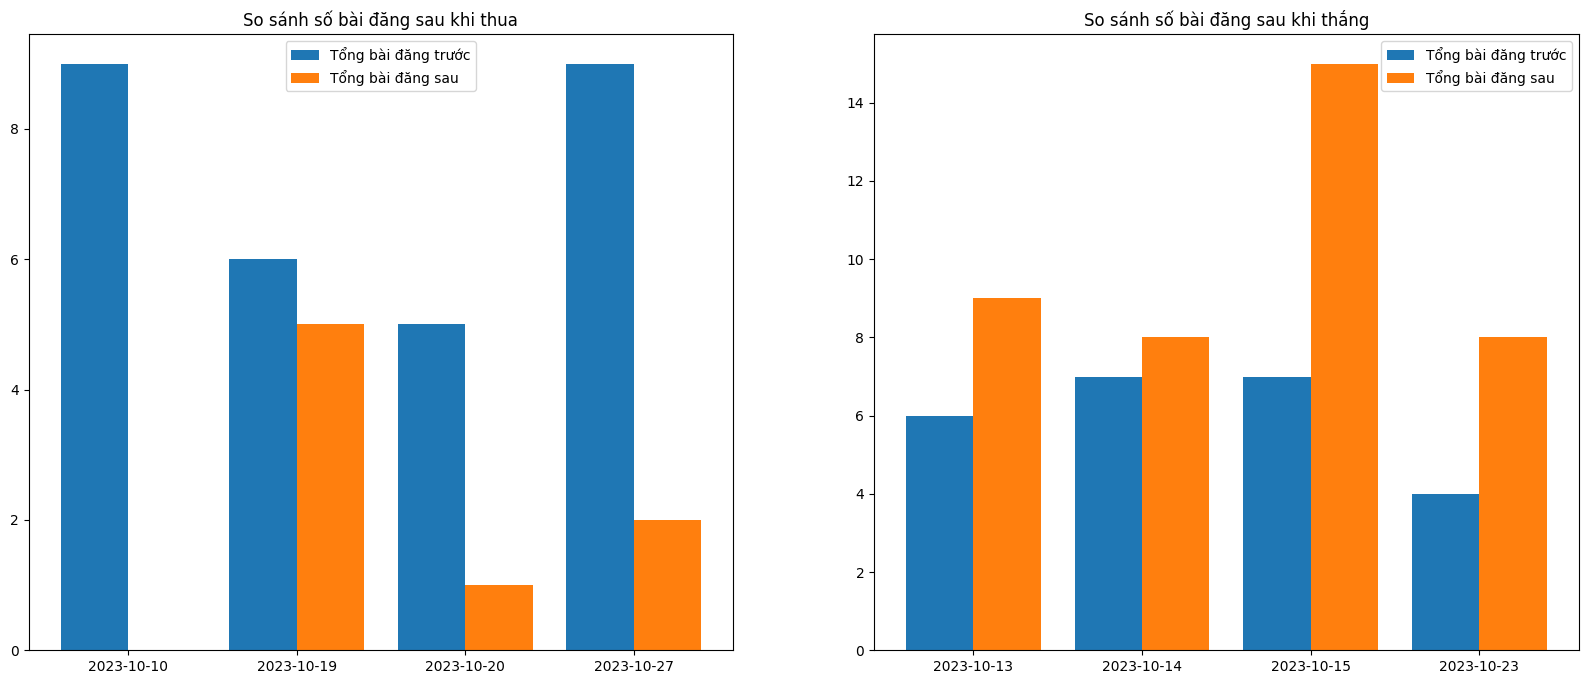

In [381]:
lose_match = day_of_match_df[day_of_match_df['result'] == 0]
win_match = day_of_match_df[day_of_match_df['result'] == 1]

fig, ax = plt.subplots(figsize = (20, 8), ncols= 2, nrows= 1)
X_axis_0 = np.arange(len(lose_match))
X_axis_1 = np.arange(len(win_match))
ax[0].bar(X_axis_0 - 0.2, lose_match['total_before'],0.4, label = "Tổng bài đăng trước" )
ax[0].bar(X_axis_0 + 0.2, lose_match['total_after'], 0.4 , label = "Tổng bài đăng sau")
ax[1].bar(X_axis_1 - 0.2, win_match['total_before'], 0.4, label = "Tổng bài đăng trước")
ax[1].bar(X_axis_1 + 0.2, win_match['total_after'], 0.4, label = "Tổng bài đăng sau")

ax[0].legend()
ax[1].legend()
ax[0].set_xticks(X_axis_0)
ax[1].set_xticks(X_axis_1)
ax[0].set_xticklabels(lose_match['date'].dt.date)
ax[1].set_xticklabels(win_match['date'].dt.date)

ax[0].set_title("So sánh số bài đăng sau khi thua")
ax[1].set_title("So sánh số bài đăng sau khi thắng")
plt.show()

In [382]:
list_of_bound_time.insert(0, reac_with_time_main['date_time'].min())
list_of_bound_time.append(reac_with_time_main['date_time'].max())

# reac_with_time_main['Range'] = pd.cut(reac_with_time_main['time'], bins = list_of_bound_time)
reac_with_time_main['Range'] = pd.cut(reac_with_time_main['date_time'], bins=list_of_bound_time)

lose_win_separate = reac_with_time_main.groupby('Range')[['yêu thích', 'phẫn nộ']].sum()

C:\Users\Asus\AppData\Local\Temp\ipykernel_7100\655771892.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reac_with_time_main['Range'] = pd.cut(reac_with_time_main['date_time'], bins=list_of_bound_time)
C:\Users\Asus\AppData\Local\Temp\ipykernel_7100\655771892.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lose_win_separate = reac_with_time_main.groupby('Range')[['yêu thích', 'phẫn nộ']].sum()


In [383]:
lose_win_separate

yêu thích  phẫn nộ
Range                                                         
(2023-10-08 20:32:36, 2023-10-10 17:00:00]     1959.0    739.0
(2023-10-10 17:00:00, 2023-10-13 14:00:00]     2972.0   2388.0
(2023-10-13 14:00:00, 2023-10-14 14:00:00]     8086.0     17.0
(2023-10-14 14:00:00, 2023-10-15 10:00:00]     7457.0      4.0
(2023-10-15 10:00:00, 2023-10-19 14:00:00]    17062.0     88.0
(2023-10-19 14:00:00, 2023-10-20 15:00:00]     1541.0    364.0
(2023-10-20 15:00:00, 2023-10-23 14:00:00]      716.0   3382.0
(2023-10-23 14:00:00, 2023-10-27 14:00:00]     8725.0     63.0
(2023-10-27 14:00:00, 2023-11-07 19:46:57]     9122.0     32.0

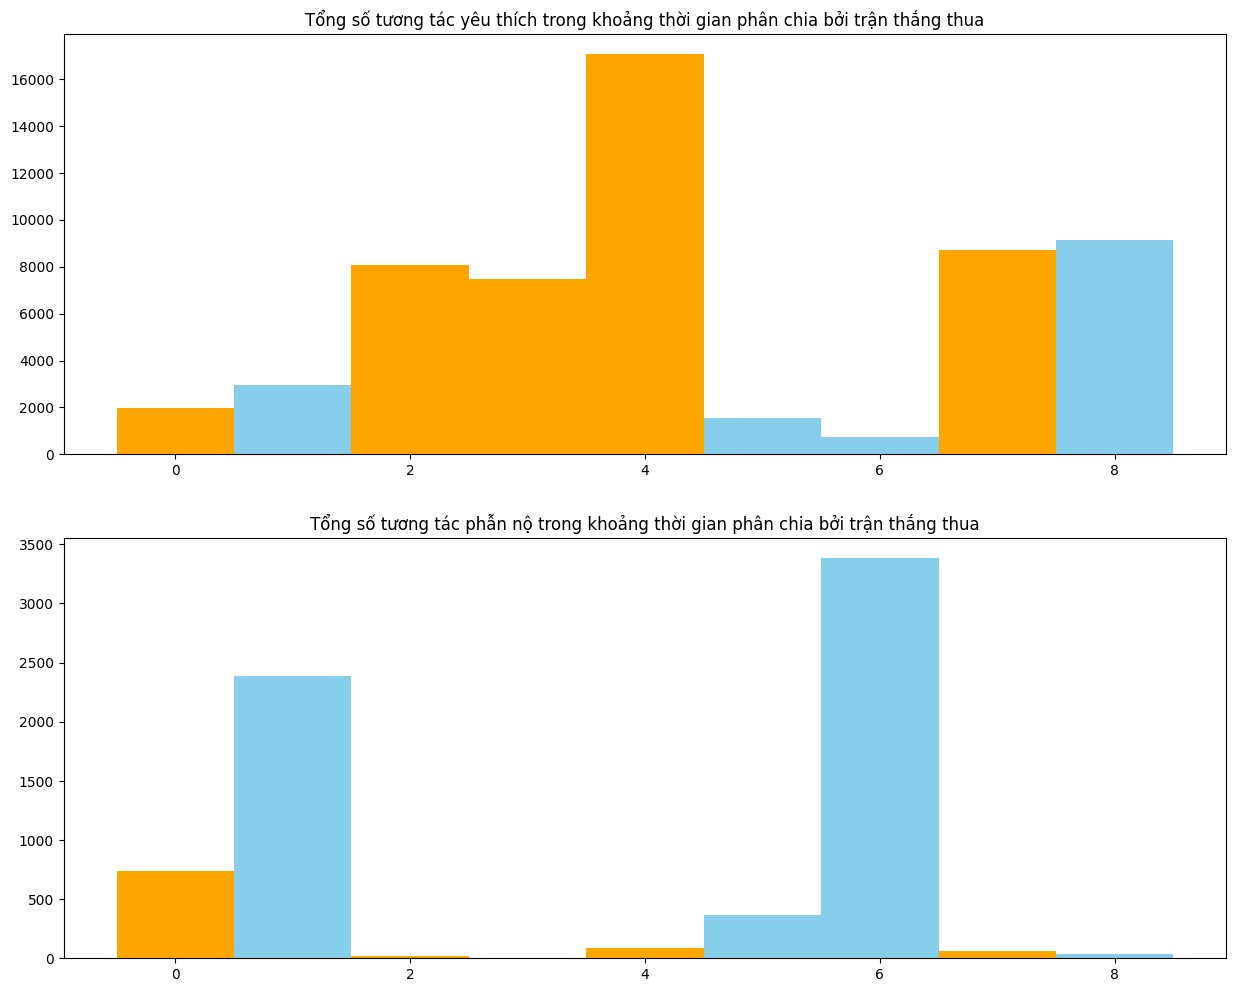

In [384]:
fig, ax = plt.subplots(nrows= 2, figsize = (15, 12))

X_axis = np.arange(9)

ax[0].bar(X_axis, lose_win_separate['yêu thích'],1, label = "Sự biến đổi của lượt thích", color=['orange', 'skyblue', 'orange', 'orange', 'orange', 'skyblue', 'skyblue', 'orange', 'skyblue'])
ax[1].bar(X_axis, lose_win_separate['phẫn nộ'],1, label = "Sự biến đổi của lượt phẫn nộ", color=['orange', 'skyblue', 'orange', 'orange', 'orange', 'skyblue', 'skyblue', 'orange', 'skyblue'])
ax[0].set_title("Tổng số tương tác yêu thích trong khoảng thời gian phân chia bởi trận thắng thua")
ax[1].set_title("Tổng số tương tác phẫn nộ trong khoảng thời gian phân chia bởi trận thắng thua")
plt.show()



## Phân tích tương tác theo nội dung post

### Phân tách dữ liệu 

In [385]:
post_content_df = main_data.loc[:,['post_text', 'thích', 'haha', 'yêu thích', 'buồn', 'thương thương', 'wow', 'phẫn nộ', 'shares', 'comments', 'reaction_count', 'date_time']]
post_content_df.head()

post_text  thích   haha  yêu thích  \
0  Palette: Góc đẹp, nhìn em mở nè anh em! 😎 #GAM...  223.0    3.0        0.0   
1  Cái gì quan trọng thì mình nhắc lại 42 lần! 🙄 ...  243.0   74.0        3.0   
2  Tâm linh không đùa được đâu! 🫣\n\nXem thêm ở M...  761.0  304.0        5.0   
3  Palette tung là anh em vào hứng ngay! 🥳 #GAMTI...  949.0    5.0       15.0   
4  Khởi đầu cho các cuộc nội chiến tại CKTG, GAM ...  878.0   16.0       90.0   

   buồn  thương thương  wow  phẫn nộ  shares  comments  reaction_count  \
0   0.0            0.0  0.0      0.0       0         9             226   
1   1.0            0.0  0.0      0.0       1        70             321   
2   7.0            2.0  0.0      0.0       6        12            1079   
3   1.0            0.0  0.0      0.0       5       128             970   
4   0.0            2.0  1.0      0.0       0        46             987   

            date_time  
0 2023-11-07 19:46:57  
1 2023-11-07 17:19:53  
2 2023-11-07 15:43:23  
3 2023-11-06 20:44:33  
4 2023-11-06 17:58:59

### Chuẩn hóa dữ liệu post

In [386]:
import re
post_content_df['post_text'] = post_content_df['post_text'].astype("string")
post_content_df['post_text'] = post_content_df['post_text'].apply(lambda x :re.sub(r'[^\w\s@/%._-]', '', x ))
from underthesea import text_normalize
post_content_df['post_text'] = post_content_df['post_text'].apply(lambda x : text_normalize(x))


In [387]:
post_content_df.dropna(inplace= True)
post_content_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197 entries, 0 to 196
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   post_text       197 non-null    object        
 1   thích           197 non-null    float64       
 2   haha            197 non-null    float64       
 3   yêu thích       197 non-null    float64       
 4   buồn            197 non-null    float64       
 5   thương thương   197 non-null    float64       
 6   wow             197 non-null    float64       
 7   phẫn nộ         197 non-null    float64       
 8   shares          197 non-null    int64         
 9   comments        197 non-null    int64         
 10  reaction_count  197 non-null    int64         
 11  date_time       197 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(7), int64(3), object(1)
memory usage: 20.0+ KB


### Số tương tác trên số bài viết theo định dạng video hoặc ảnh 

C:\Users\Asus\AppData\Local\Temp\ipykernel_7100\3102082959.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reac_with_time_main['is_video_post'] = main_data['video']
C:\Users\Asus\AppData\Local\Temp\ipykernel_7100\3102082959.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reac_with_time_main['is_img_post'] = main_data['image']


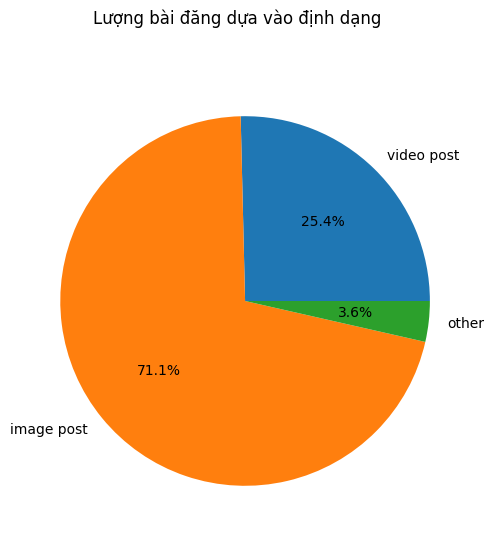

In [388]:
# Các định dạng chủ yếu của bài đăng 
reac_with_time_main['is_video_post'] = main_data['video']
reac_with_time_main['is_img_post'] = main_data['image']

total_post = len(main_data)
total_video_post = reac_with_time_main['is_video_post'].sum()
total_img_post = reac_with_time_main['is_img_post'].sum()
other_post = total_post - total_img_post - total_video_post

post_type = pd.Series([total_video_post, total_img_post, other_post], index = ['video post', 'image post', 'other'])
plot = post_type.plot.pie(figsize = (6, 6), subplots=True, autopct='%1.1f%%', title = "Lượng bài đăng dựa vào định dạng")

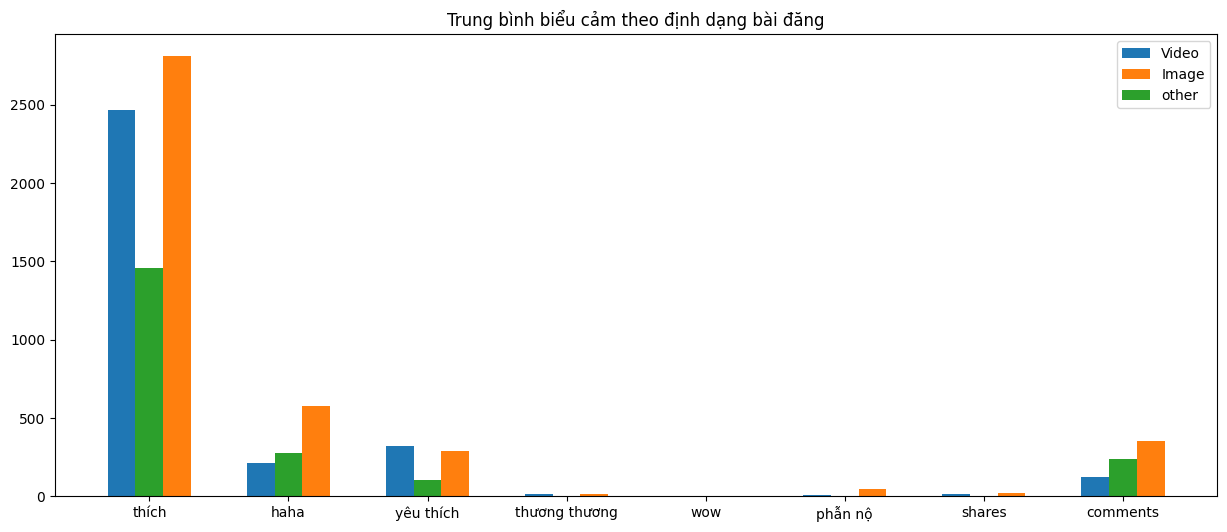

In [389]:

# tương tác người dùng dựa vào loại nội dung
video_main = reac_with_time_main.groupby('is_video_post')[['thích', 'haha', 'yêu thích', 'thương thương', 'wow', 'phẫn nộ', 'shares', 'comments']].mean()
other_main = reac_with_time_main[(~reac_with_time_main['is_img_post']) & (~reac_with_time_main['is_video_post'])].loc[:,['thích', 'haha', 'yêu thích', 'thương thương', 'wow', 'phẫn nộ', 'shares', 'comments']].mean()
img_main = reac_with_time_main.groupby('is_img_post')[['thích', 'haha', 'yêu thích', 'thương thương', 'wow', 'phẫn nộ', 'shares', 'comments']].mean()
video_main = video_main.loc[True, :]
img_main = img_main.loc[True, :]

fig, ax = plt.subplots(figsize = (15, 6))

X_ax = np.arange(8)

ax.bar(X_ax - 0.2, video_main, 0.2, label='Video')
ax.bar(X_ax + 0.2, img_main, 0.2, label='Image')
ax.bar(X_ax, other_main, 0.2, label = 'other')

ax.set_xticks(X_ax)
ax.set_xticklabels(['thích', 'haha', 'yêu thích', 'thương thương', 'wow', 'phẫn nộ', 'shares', 'comments'])
ax.set_title("Trung bình biểu cảm theo định dạng bài đăng")
ax.legend()

plt.show()

### Phân tích những từ quan trọng trong post

In [390]:
## Lấy từ điển stop word tiếng việt (Kaggle)
stop_word = pd.read_csv('Data\\vietnamese.txt')
stop_word

Word
0                     a lô
1                     a ha
2                       ai
3                    ai ai
4                   ai nấy
...                    ...
1949  riseasone worlds2024
1950            worlds2024
1951     gamtime riseasone
1952            worlds2023
1953  riseasone worlds2023

[1954 rows x 1 columns]

In [391]:
"""
- Tách từ ra khỏi câu
- Loại bỏ stopword ra khỏi các từ
- Hợp nhất thành 1 văn bản chính
"""
from underthesea import word_tokenize

def handle_string(post_content_df, idx) :
    text = ""
    word_content_lst = []
    for i in post_content_df[idx] :
        r = word_tokenize(i)
        for j in r : 
            tmp = j.lower()
            if  tmp not in stop_word['Word'].values : 
                word_content_lst.append(j)
                text = text + " " + j
    
    return (word_content_lst, text)

word_content_lst, text = handle_string(post_content_df, "post_text")


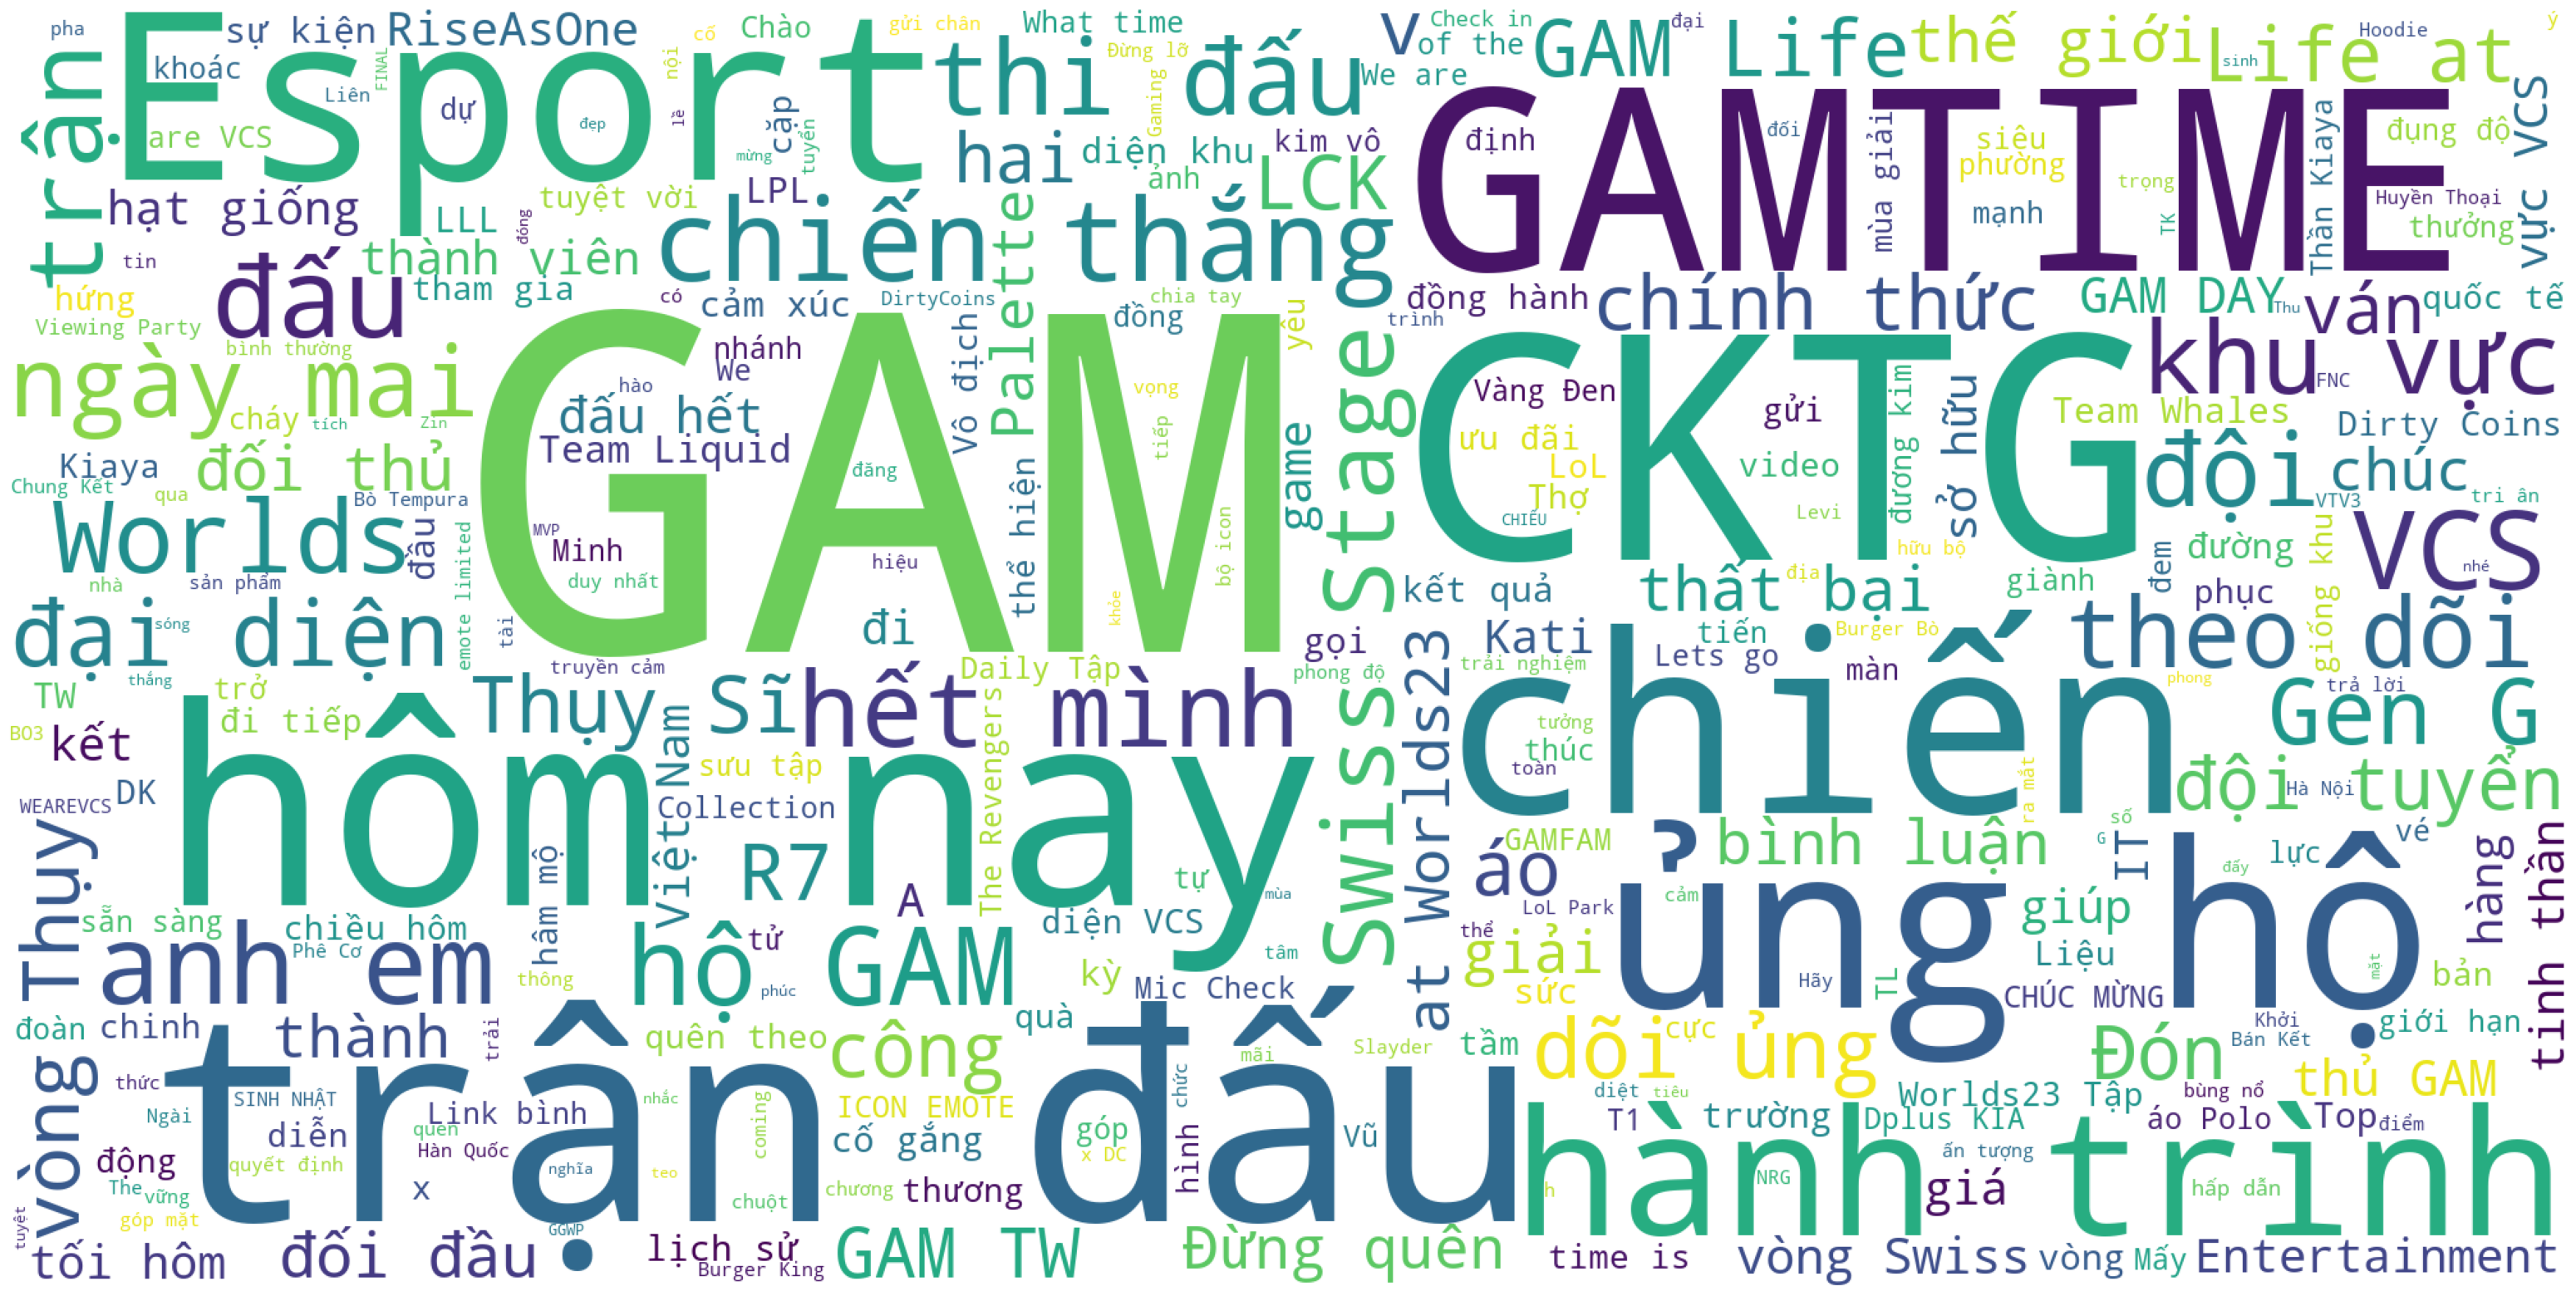

In [392]:
# Biểu diễn tần suất những từ xuất hiện trong tất cả bài post
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(stopwords=stop_word,
                          background_color='white', 
                      max_words=300,
                      width=2000, height=1000
                         ).generate(text)
plt.figure(figsize=(40,20))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Lấy 10 bài viết có lượng tương tác cao nhất

In [393]:
top_10_reac_post = post_content_df.sort_values(by = "reaction_count", ascending = False).head(20)
top_10_reac_post

post_text    thích    haha  \
114                       GAMTIME RiseAsOne Worlds2023  11242.0  7747.0   
125                     PSG TALON RiseAsOne Worlds2023  11058.0  5293.0   
141  Trận chiến lịch sử của các đại diện VCS tại đấ...  13845.0   153.0   
126  Cảm xúc nghẹn ngào của anh TK Nguyễn sau màn t...  13012.0    57.0   
67                        GAMTIME RiseAsOne Worlds2023   8335.0  4680.0   
36                    Its wedding time Đã đến lúc cưới   9717.0   939.0   
166                   CKTG à SLAYDER TỚI CHƠI BROOOOOO   9217.0  1490.0   
69   Bản tin VTV3 đưa tin về chiến thắng đầy thuyết...   9489.0   272.0   
76   GAM 2 - 1 TL GAM không dễ bị khuất phục như vậ...   8500.0   801.0   
142  Đưa thương hiệu Việt ra thế giới GAMTIME RiseA...   7033.0  2490.0   
118  Bảo sao cứ cảm thấy quen quen GAMTIME RiseAsOn...   5424.0  4137.0   
147  Truyện cười cuối ngày GAMTIME RiseAsOne Worlds...   4294.0  5156.0   
37   Cả team nín thở xem Kiaya PK GAMTIME RiseAsOne...   9216.0   297.0   
167  GAM 2 - 0 R7 WHAT TIME IS ITTTTTTT GAMTIME Ris...   7335.0   677.0   
113      Mission complete GAMTIME RiseAsOne Worlds2023   5620.0  3625.0   
150  GAM 2 - 0 LLL Chào Team Whales LoL Esports lâu...   6897.0   946.0   
70   Đi thi đấu cũng nhàn GAMTIME RiseAsOne Worlds2023   7100.0   170.0   
129  Lời tri ân dành cho Team Whales LoL Esports mọ...   6571.0    10.0   
158  Cảm ơn VTV3 đã đưa tin về chiến thắng của GAM ...   6533.0   758.0   
106  Tại CKTG2022 tại New York GAM đã gây sốc cho t...   6743.0   157.0   

     yêu thích    buồn  thương thương   wow  phẫn nộ  shares  comments  \
114      158.0   127.0           26.0  32.0      5.0     134       530   
125      149.0  1596.0           46.0  26.0      2.0      48       422   
141     2198.0    18.0           73.0  19.0      0.0      67       238   
126     2911.0    16.0           98.0   6.0      0.0      60       281   
67        60.0    87.0           15.0  13.0      1.0      30       166   
36      1855.0     7.0           70.0  11.0      0.0      29       133   
166     1463.0    14.0           51.0  15.0      1.0     165       867   
69      1430.0    10.0           41.0  16.0      2.0      98       327   
76      1763.0     5.0           71.0  17.0      3.0     274      1677   
142      132.0    32.0           21.0   9.0      0.0      29        83   
118       36.0    59.0           12.0   9.0      0.0      31       178   
147       35.0   101.0           13.0  15.0      2.0      38       303   
37        64.0     3.0            3.0   2.0      1.0      19       325   
167     1338.0    12.0           32.0  10.0      4.0     179      1061   
113       71.0    48.0           15.0   8.0      1.0      43       172   
150     1288.0    10.0           40.0  10.0      1.0     223       990   
70       191.0  1062.0           72.0  23.0      0.0      25       335   
129     1771.0     4.0           62.0   8.0      3.0      16       302   
158      894.0    11.0           32.0  13.0      1.0      33       116   
106     1251.0    11.0           40.0  15.0      2.0      60       288   

     reaction_count           date_time  
114           19337 2023-10-17 10:35:48  
125           18170 2023-10-15 18:06:52  
141           16306 2023-10-15 08:00:01  
126           16100 2023-10-15 16:06:17  
67            13191 2023-10-24 16:55:21  
36            12599 2023-10-30 19:28:23  
166           12251 2023-10-13 15:29:39  
69            11260 2023-10-24 13:05:18  
76            11160 2023-10-23 16:21:36  
142            9717 2023-10-15 07:42:59  
118            9677 2023-10-16 18:51:48  
147            9616 2023-10-14 17:02:02  
37             9586 2023-10-30 19:24:55  
167            9408 2023-10-13 15:27:47  
113            9388 2023-10-17 11:57:01  
150            9192 2023-10-14 15:44:55  
70             8618 2023-10-24 11:17:43  
129            8429 2023-10-15 13:55:47  
158            8242 2023-10-14 09:25:56  
106            8219 2023-10-18 13:47:49

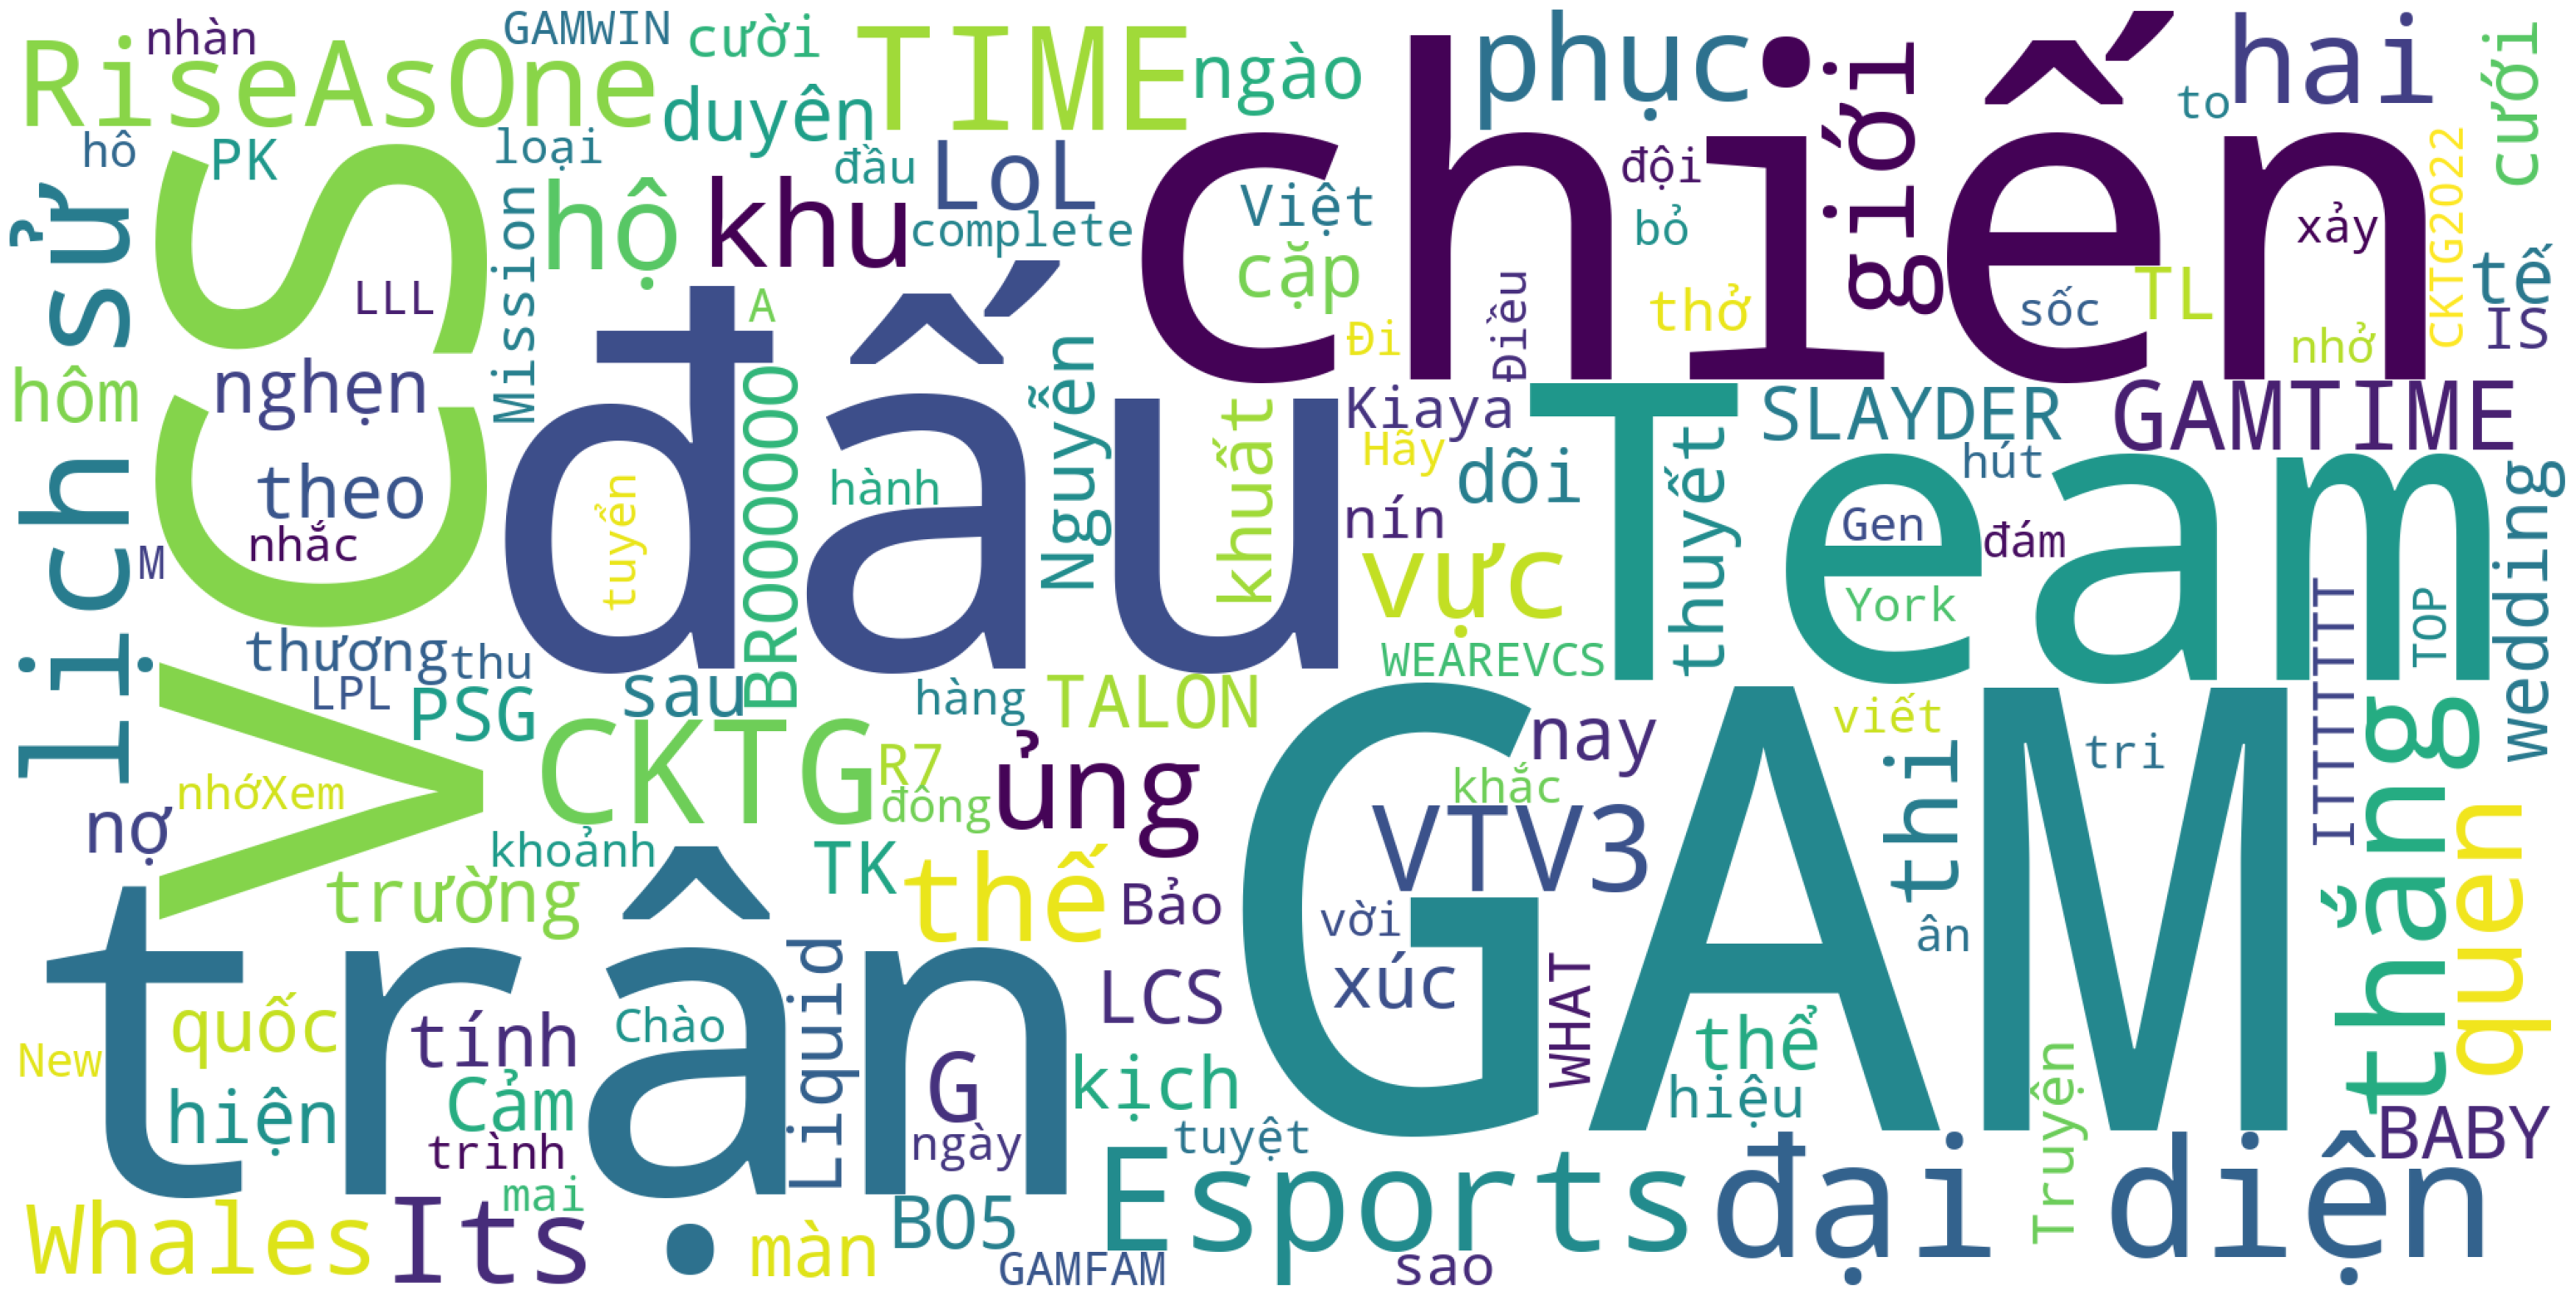

In [394]:
top_10_reac_post_lst, top_10_text = handle_string(top_10_reac_post, "post_text")

wordcloud_top_10 = WordCloud(stopwords=stop_word,
                          background_color='white', 
                      max_words=300,
                      width=2000, height=1000
                         ).generate(top_10_text)

plt.figure(figsize=(40,20))
plt.clf()
plt.imshow(wordcloud_top_10)
plt.axis('off')
plt.show()

### 10 keyword xuất hiện trong bài viết
- Sử dụng phương pháp tính chỉ số tf-idf để đánh giá mức độ quan trọng, tần suất của keyword

In [395]:
import math

# Tính chỉ số tf của các từ 
def find_tf(word_content_lst) : 
    tf = {}

    for i in word_content_lst : 
        if (i not in tf) : tf[i] = 0
        tf[i] += 1

    tf.update((x, y/int(len(word_content_lst))) for x, y in tf.items())
    return tf



# Tính chỉ số idf của từ 
def find_idf(word_content_lst, post_content_df) : 
    idf = {}
    for i in word_content_lst : 
        if i not in idf : idf[i] = 0
        for j in post_content_df['post_text'] : 
            if i in j : idf[i] += 1
    idf.update((x, math.log( len(post_content_df['post_text']) / y, math.e)) for x,y in idf.items())
    return idf


# tính chỉ số tf_idf của từ
def find_tf_idf(word_content_lst, post_content_df) : 
    tf_idf = {}
    tf = find_tf(word_content_lst)
    idf = find_idf(word_content_lst, post_content_df)
    for i in tf.keys() : 
        tf_idf[i] = tf[i] * idf[i]
    return tf_idf

tf_idf = find_tf_idf(word_content_lst, post_content_df)


In [396]:
# lấy 10 từ khóa 
sorted_items = sorted(tf_idf.items(), key=lambda x: x[1], reverse=True)[:10]
for i in sorted_items : 
    print(i)

('video', 0.007280550567387807)
('GAM Entertainment', 0.007280550567387807)
('Việt Nam', 0.005412998228275661)
('quà', 0.005103356178430001)
('sự kiện', 0.005079290031007773)
('phường', 0.005079290031007773)
('Palette', 0.005006301779762289)
('Kati', 0.005006301779762289)
('sản phẩm', 0.004975732984625301)
('thành viên', 0.004793892061331758)


In [397]:

top_10_tf_idf = find_tf_idf(top_10_reac_post_lst,top_10_reac_post)
sorted_items_top_10 = sorted(top_10_tf_idf.items(), key=lambda x: x[1], reverse=True)[:10]
for i in sorted_items_top_10 : 
    print(i)

('trận', 0.025985024553797184)
('khu vực', 0.023157380035023028)
('ủng hộ', 0.023157380035023028)
('hai', 0.023157380035023028)
('VTV3', 0.023157380035023028)
('thế giới', 0.023157380035023028)
('thi đấu', 0.023157380035023028)
('lịch sử', 0.023157380035023028)
('PSG', 0.02155203074499274)
('TALON RiseAsOne', 0.02155203074499274)


## Phân tích Comment

### Lấy dữ liệu vào
- Các cột cần phân tích : comments, comments_full, date, time_hour, post_text, reaction_count, post_id
- Tạo thêm một dataframe chứa comments_full của từng bài viết

In [398]:

comments_df = main_data.loc[:, ['post_id', 'date', 'time_hour','post_text', 'comments', 'comments_full', 'reaction_count', 'date_time' ]]
comments_df

post_id       date  time_hour  \
0    737976521702400 2023-11-07         19   
1    737919055041480 2023-11-07         17   
2    737886838378035 2023-11-07         15   
3    737500015083384 2023-11-06         20   
4    737427961757256 2023-11-06         17   
..               ...        ...        ...   
192  720729766760409 2023-10-09         19   
193  720681966765189 2023-10-09         17   
194  720637733436279 2023-10-09         15   
195  720564523443600 2023-10-09         12   
196  720151933484859 2023-10-08         20   

                                             post_text  comments  \
0    Palette: Góc đẹp, nhìn em mở nè anh em! 😎 #GAM...         9   
1    Cái gì quan trọng thì mình nhắc lại 42 lần! 🙄 ...        70   
2    Tâm linh không đùa được đâu! 🫣\n\nXem thêm ở M...        12   
3    Palette tung là anh em vào hứng ngay! 🥳 #GAMTI...       128   
4    Khởi đầu cho các cuộc nội chiến tại CKTG, GAM ...        46   
..                                                 ...       ...   
192  Check-in tại LoL Park, chuẩn bị cho trận đấu đ...       180   
193  [THÔNG BÁO CHÍNH THỨC]\n\nGAM Entertainment ch...       107   
194  Chairman Randy Dobson, CEO TK Nguyễn cũng như ...         4   
195  Bình thường Kiaya nhoi lắm, hôm nay ảnh chill ...        45   
196  We are VCS, we RISE AS ONE! 🇻🇳\n\n#GAMTIME #Ri...        12   

                                         comments_full  reaction_count  \
0    [{'comment_id': '687445613484826', 'comment_ur...             226   
1    [{'comment_id': '1060101512081817', 'comment_u...             321   
2    [{'comment_id': '300064389519874', 'comment_ur...            1079   
3    [{'comment_id': '312106058277547', 'comment_ur...             970   
4    [{'comment_id': '839663224521349', 'comment_ur...             987   
..                                                 ...             ...   
192  [{'comment_id': '1306640400732934', 'comment_u...            2496   
193  [{'comment_id': '1304445783532817', 'comment_u...            5019   
194  [{'comment_id': '1367561214109946', 'comment_u...             416   
195  [{'comment_id': '701663508093455', 'comment_ur...            1025   
196  [{'comment_id': '291996963638649', 'comment_ur...             237   

              date_time  
0   2023-11-07 19:46:57  
1   2023-11-07 17:19:53  
2   2023-11-07 15:43:23  
3   2023-11-06 20:44:33  
4   2023-11-06 17:58:59  
..                  ...  
192 2023-10-09 19:06:49  
193 2023-10-09 17:22:07  
194 2023-10-09 15:25:56  
195 2023-10-09 12:14:10  
196 2023-10-08 20:32:36  

[197 rows x 8 columns]

In [399]:
comments_df.index = comments_df['post_id']
comments_df.drop('post_id', inplace = True, axis = 1)
comments_df.head()

date  time_hour  \
post_id                                 
737976521702400 2023-11-07         19   
737919055041480 2023-11-07         17   
737886838378035 2023-11-07         15   
737500015083384 2023-11-06         20   
737427961757256 2023-11-06         17   

                                                         post_text  comments  \
post_id                                                                        
737976521702400  Palette: Góc đẹp, nhìn em mở nè anh em! 😎 #GAM...         9   
737919055041480  Cái gì quan trọng thì mình nhắc lại 42 lần! 🙄 ...        70   
737886838378035  Tâm linh không đùa được đâu! 🫣\n\nXem thêm ở M...        12   
737500015083384  Palette tung là anh em vào hứng ngay! 🥳 #GAMTI...       128   
737427961757256  Khởi đầu cho các cuộc nội chiến tại CKTG, GAM ...        46   

                                                     comments_full  \
post_id                                                              
737976521702400  [{'comment_id': '687445613484826', 'comment_ur...   
737919055041480  [{'comment_id': '1060101512081817', 'comment_u...   
737886838378035  [{'comment_id': '300064389519874', 'comment_ur...   
737500015083384  [{'comment_id': '312106058277547', 'comment_ur...   
737427961757256  [{'comment_id': '839663224521349', 'comment_ur...   

                 reaction_count           date_time  
post_id                                              
737976521702400             226 2023-11-07 19:46:57  
737919055041480             321 2023-11-07 17:19:53  
737886838378035            1079 2023-11-07 15:43:23  
737500015083384             970 2023-11-06 20:44:33  
737427961757256             987 2023-11-06 17:58:59

### Xử lý dữ liệu cột comment full 


In [400]:
# Dataframe chứa thông tin gốc
dct_origin = {'post_id' : [],  'comment_id' : [], 'commenter_name' : [], 'comment_url' : [], 'commenter_meta' : [], 'commenter_id' : [], 'commenter_url' : [], 'comment_text' : [], 
              'like' : [], 'haha' : [], 'sad' : [], 'love' : [], 'care' : [],
              'wow' : [], 'angry' : [], 'comment_reaction_count' : [], 'is_reply' : []}

def dct_help(j_obj,idx,  dct_origin) :
    for j in range(len(j_obj)) : 
        for k in dct_origin.keys() : 
            if k in j_obj[j] : 
                dct_origin[k].append(j_obj[j][k])
            elif k == 'is_reply' : 
                dct_origin[k].append('replies' not in j_obj[j].keys())
            elif k == 'post_id' : 
                dct_origin[k].append(idx)
            elif j_obj[j]['comment_reactions'] and k in j_obj[j]['comment_reactions'] : 
                dct_origin[k].append(j_obj[j]['comment_reactions'][k])
            else : 
                dct_origin[k].append(0)

for i in range(len(comments_df['comments_full'])) :
    idx = comments_df.index[i] 
    j_obj = eval(comments_df.loc[idx, 'comments_full'])

    dct_help(j_obj,idx, dct_origin)
    for j in range(len(j_obj)) :
        dct_help(j_obj[j]['replies'],idx,  dct_origin)
    
origin_cmt_df = pd.DataFrame(dct_origin)
cmt_df_idx = origin_cmt_df['post_id']
origin_cmt_df.head()


post_id        comment_id commenter_name  \
0  737976521702400   687445613484826       Ngô Tuấn   
1  737976521702400  6766375476749289     Hoàng Hoạt   
2  737976521702400   889568115848198      Khương Vũ   
3  737976521702400   874599703945064          Ht271   
4  737976521702400   853331139670600    Dương Phong   

                             comment_url commenter_meta     commenter_id  \
0   https://facebook.com/687445613484826       Fan cứng  100032860689002   
1  https://facebook.com/6766375476749289           None  100043315503165   
2   https://facebook.com/889568115848198       Fan cứng  100008777650405   
3   https://facebook.com/874599703945064           None   61552993208509   
4   https://facebook.com/853331139670600           None  100069500763685   

                                       commenter_url  \
0  https://facebook.com/profile.php?id=1000328606...   
1  https://facebook.com/profile.php?id=1000433155...   
2  https://facebook.com/khuongkts?eav=AfYOQ02kFte...   
3  https://facebook.com/profile.php?id=6155299320...   
4  https://facebook.com/profile.php?id=1000695007...   

                                        comment_text  like  haha  sad  love  \
0  Đăng mic check vs TL đi chứ đánh với anh em mộ...     6     0    0     0   
1                       Nghe nói fiddlesticks cút hả     0     0    0     0   
2  Hôm nghe bảo về fam lại mà mấy bố kêu về fam n...     0     0    0     0   
3          Anh Khánh đi bộ nai xừ chưa về live nữa 😂     0     0    0     0   
4                                        Dương Phong     0     0    0     0   

   care  wow  angry  comment_reaction_count  is_reply  
0     0    0      0                     6.0     False  
1     0    0      0                     NaN     False  
2     0    0      0                     NaN     False  
3     0    0      0                     NaN     False  
4     0    0      0                     NaN     False

In [401]:
commenter_meta_tmp =  origin_cmt_df['commenter_meta'].fillna(value =  "Bình thường")

In [402]:
origin_cmt_df['comment_reaction_count'] = origin_cmt_df.loc[:,['like', 'haha', 'sad', 'love', 'care', 'wow', 'angry']].sum(axis=1)
origin_cmt_df.head()

post_id        comment_id commenter_name  \
0  737976521702400   687445613484826       Ngô Tuấn   
1  737976521702400  6766375476749289     Hoàng Hoạt   
2  737976521702400   889568115848198      Khương Vũ   
3  737976521702400   874599703945064          Ht271   
4  737976521702400   853331139670600    Dương Phong   

                             comment_url commenter_meta     commenter_id  \
0   https://facebook.com/687445613484826       Fan cứng  100032860689002   
1  https://facebook.com/6766375476749289           None  100043315503165   
2   https://facebook.com/889568115848198       Fan cứng  100008777650405   
3   https://facebook.com/874599703945064           None   61552993208509   
4   https://facebook.com/853331139670600           None  100069500763685   

                                       commenter_url  \
0  https://facebook.com/profile.php?id=1000328606...   
1  https://facebook.com/profile.php?id=1000433155...   
2  https://facebook.com/khuongkts?eav=AfYOQ02kFte...   
3  https://facebook.com/profile.php?id=6155299320...   
4  https://facebook.com/profile.php?id=1000695007...   

                                        comment_text  like  haha  sad  love  \
0  Đăng mic check vs TL đi chứ đánh với anh em mộ...     6     0    0     0   
1                       Nghe nói fiddlesticks cút hả     0     0    0     0   
2  Hôm nghe bảo về fam lại mà mấy bố kêu về fam n...     0     0    0     0   
3          Anh Khánh đi bộ nai xừ chưa về live nữa 😂     0     0    0     0   
4                                        Dương Phong     0     0    0     0   

   care  wow  angry  comment_reaction_count  is_reply  
0     0    0      0                       6     False  
1     0    0      0                       0     False  
2     0    0      0                       0     False  
3     0    0      0                       0     False  
4     0    0      0                       0     False

In [403]:
origin_cmt_df.to_csv('Data\comment_summary.csv', index = False)

In [404]:
origin_cmt_df = pd.read_csv('Data\comment_summary_solv.csv')
origin_cmt_df['post_id'] = cmt_df_idx
origin_cmt_df.drop('comment_time', inplace = True, axis = 1)
origin_cmt_df['commenter_meta'] = commenter_meta_tmp

In [405]:
origin_cmt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6885 entries, 0 to 6884
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   comment_id              6885 non-null   int64 
 1   comment_url             6885 non-null   object
 2   commenter_id            6885 non-null   int64 
 3   commenter_url           6885 non-null   object
 4   comment_text            6885 non-null   object
 5   like                    6885 non-null   int64 
 6   haha                    6885 non-null   int64 
 7   sad                     6885 non-null   int64 
 8   love                    6885 non-null   int64 
 9   care                    6885 non-null   int64 
 10  wow                     6885 non-null   int64 
 11  angry                   6885 non-null   int64 
 12  comment_reaction_count  6885 non-null   int64 
 13  is_reply                6885 non-null   bool  
 14  sentiment               6885 non-null   object
 15  post

### Thống kê biểu cảm 

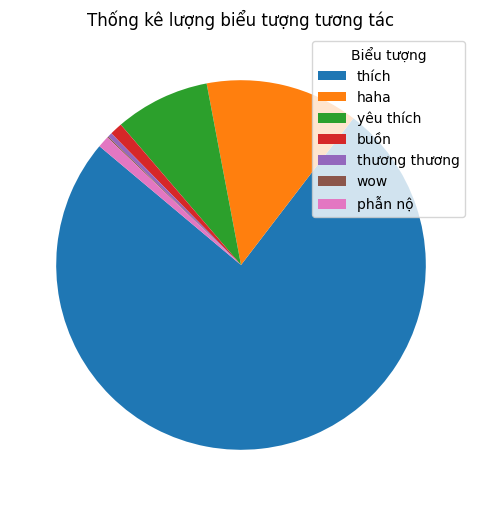

In [406]:
descrip_reac = main_data.loc[:,['thích', 'haha', 'yêu thích', 'buồn', 'thương thương', 'wow', 'phẫn nộ']]

plt.figure(figsize=(6, 6))
plt.title("Thống kê lượng biểu tượng tương tác")
plt.pie(descrip_reac.sum(), startangle=140)

# Thêm chú thích (legend)
plt.legend(title="Biểu tượng", loc="upper right", labels = descrip_reac.columns)

# Hiển thị biểu đồ
plt.show()


### Tỷ lệ bình luận tiêu cực và tích cực

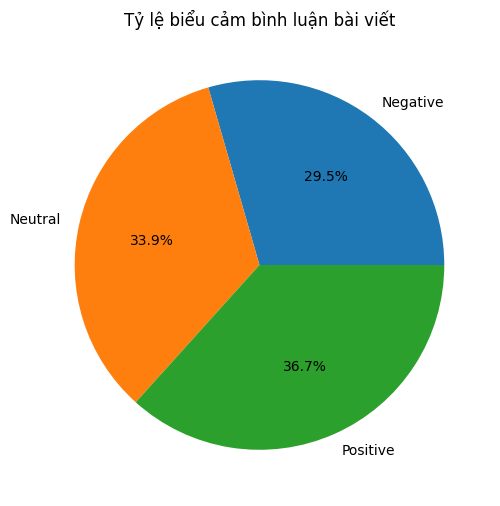

In [407]:
sentiment_count = origin_cmt_df.groupby('sentiment')['comment_id'].count()
sentiment_count_plot = sentiment_count.plot.pie(figsize = (6, 6), autopct='%1.1f%%', title = "Tỷ lệ biểu cảm bình luận bài viết", label = "")

### Biểu cảm bình luận bài viết tập trung vào thời gian nào 

In [408]:
comments_for_time = comments_df['date_time'].reset_index()
comments_for_time = pd.merge(origin_cmt_df, comments_for_time, left_on= "post_id", right_on= "post_id", how = "left")
comments_for_time = comments_for_time.loc[:, ['post_id', "sentiment", "date_time"]]
comments_for_time = comments_for_time.groupby(['date_time', 'sentiment']).size().reset_index(name='count')
comments_for_time_format = comments_for_time.pivot_table(index='date_time', columns='sentiment', values='count', fill_value=0)
comments_for_time_format = comments_for_time_format.reset_index()
comments_for_time_format.head()

sentiment           date_time  Negative  Neutral  Positive
0         2023-10-08 20:32:36       1.0      3.0       5.0
1         2023-10-09 12:14:10      20.0     11.0      11.0
2         2023-10-09 15:25:56       1.0      1.0       2.0
3         2023-10-09 17:22:07       8.0     20.0      23.0
4         2023-10-09 19:06:49      12.0     28.0      23.0

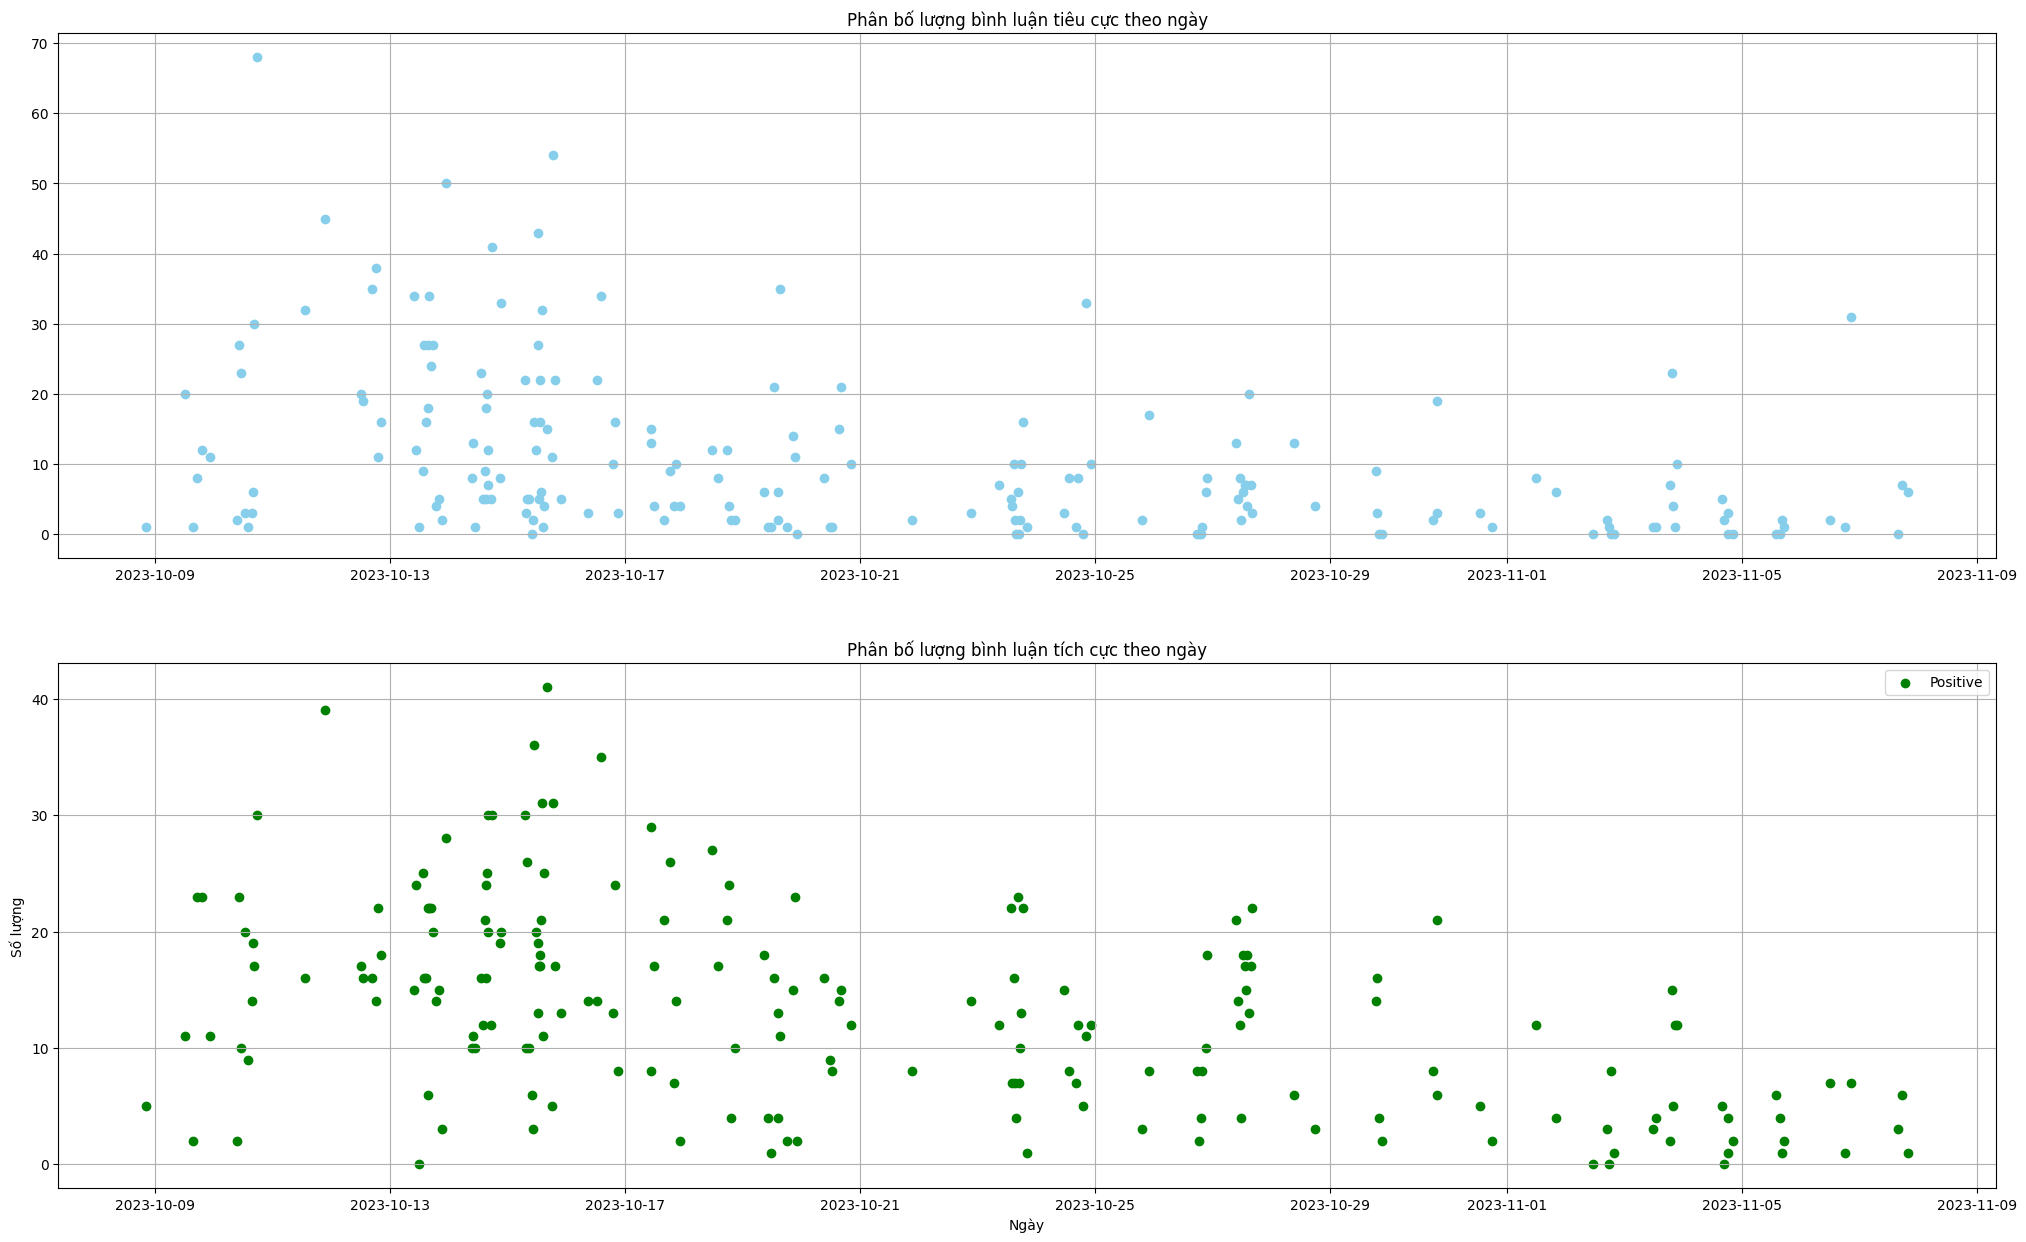

In [409]:
fig, ax = plt.subplots(figsize=(25, 15), nrows = 2, ncols= 1)

ax[0].scatter(comments_for_time_format['date_time'], comments_for_time_format['Negative'], label='Negative', color='skyblue')

ax[1].scatter(comments_for_time_format['date_time'], comments_for_time_format['Positive'], label='Positive', color='green')

ax[0].grid(True)
ax[1].grid(True)
ax[0].set_title("Phân bố lượng bình luận tiêu cực theo ngày")
ax[1].set_title("Phân bố lượng bình luận tích cực theo ngày")
plt.xlabel('Ngày')
plt.ylabel('Số lượng')
plt.legend()
plt.show()

### Tỉ lệ biểu cảm bình luận dựa vào phân loại người dùng

In [410]:
comment_per_meta = origin_cmt_df.loc[:, ['sentiment', 'commenter_meta', "post_id"]]

comment_per_meta_class_person = comment_per_meta.groupby(["commenter_meta", "sentiment"]).size().reset_index(name='count')
comment_per_meta_wide_format = comment_per_meta_class_person.pivot_table(index='commenter_meta', columns='sentiment', values='count', fill_value=0)
comment_per_meta_wide_format

sentiment                      Negative  Neutral  Positive
commenter_meta                                            
Bình thường                      1381.0   1580.0    1505.0
Fan cứng                          640.0    745.0     945.0
Người theo dõi                      1.0      0.0       1.0
Người theo dõi mốc quan trọng       1.0      0.0       0.0
Người theo dõi thâm niên            1.0      1.0       1.0
Tác giả                             4.0      5.0      73.0
Đối tác                             1.0      0.0       0.0

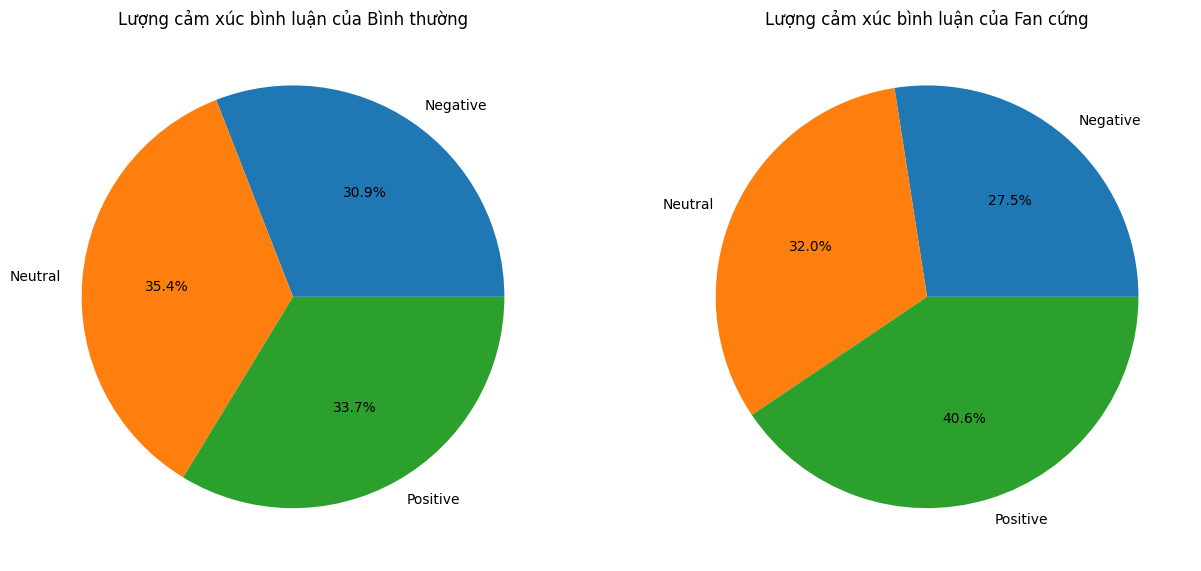

In [411]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
ax[0].pie( comment_per_meta_wide_format.loc["Bình thường", :], labels = comment_per_meta_wide_format.loc["Bình thường", :].index, autopct='%1.1f%%')
ax[1].pie(comment_per_meta_wide_format.loc["Fan cứng", :], labels = comment_per_meta_wide_format.loc["Fan cứng", :].index, autopct='%1.1f%%')
ax[0].set_title("Lượng cảm xúc bình luận của Bình thường")
ax[1].set_title("Lượng cảm xúc bình luận của Fan cứng")
plt.show()


### Bình luận này có phải reply không ? 

In [412]:
comment_per_reply = origin_cmt_df.loc[:, ['commenter_id', 'commenter_meta', 'is_reply']]
comment_per_reply_meta = comment_per_reply[(comment_per_reply['commenter_meta'] == 'Bình thường') | (comment_per_reply['commenter_meta'] == 'Fan cứng')].groupby(['commenter_id', 'commenter_meta'])['is_reply'].mean()
comment_per_reply_meta_df = comment_per_reply_meta.reset_index()

In [413]:
comment_per_reply_meta_df.head()

commenter_id commenter_meta  is_reply
0     567913602    Bình thường  1.000000
1     624881816    Bình thường  0.146341
2     693234462       Fan cứng  1.000000
3     701203671    Bình thường  0.000000
4     703077979    Bình thường  0.000000

C:\Users\Asus\AppData\Local\Temp\ipykernel_7100\1725381729.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(x='commenter_meta', y='is_reply', data=comment_per_reply_meta_df, palette='rainbow')


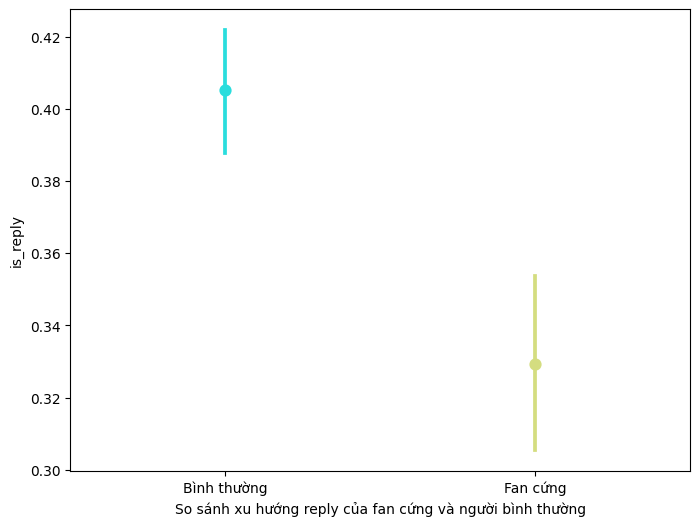

In [414]:
plt.figure(figsize=(8, 6))
sns.pointplot(x='commenter_meta', y='is_reply', data=comment_per_reply_meta_df, palette='rainbow')

plt.xlabel('So sánh xu hướng reply của fan cứng và người bình thường')

plt.show()

### So sánh số lượng tương tác giữa 2 lượt bình luận

In [415]:
comment_per_reac = origin_cmt_df.loc[:, ['commenter_id', 'commenter_meta', 'comment_reaction_count']]
comment_per_reac_meta = comment_per_reac[(comment_per_reac['commenter_meta'] == 'Bình thường') | (comment_per_reac['commenter_meta'] == 'Fan cứng')].groupby(['commenter_id', 'commenter_meta'])['comment_reaction_count'].mean()
comment_per_reac_meta = comment_per_reac_meta.reset_index()

In [416]:
comment_per_reac_meta.head()

commenter_id commenter_meta  comment_reaction_count
0     567913602    Bình thường                     0.0
1     624881816    Bình thường                     0.0
2     693234462       Fan cứng                     0.0
3     701203671    Bình thường                     0.0
4     703077979    Bình thường                     0.0

C:\Users\Asus\AppData\Local\Temp\ipykernel_7100\2482130155.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(x='commenter_meta', y='comment_reaction_count', data=comment_per_reac_meta, palette='rainbow')


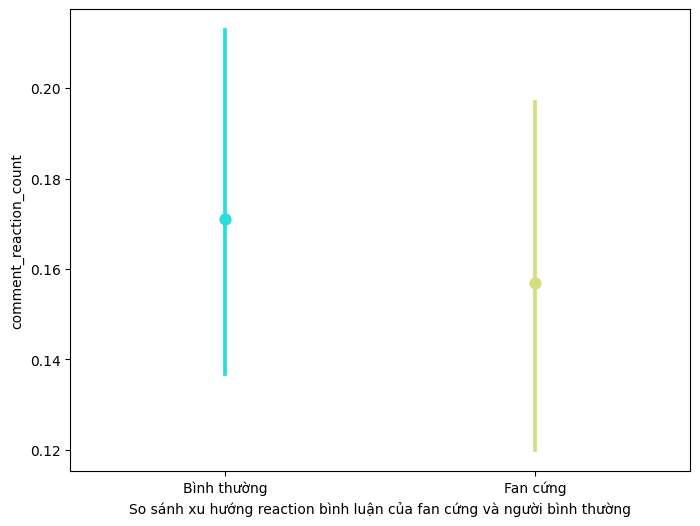

In [417]:
plt.figure(figsize=(8, 6))
sns.pointplot(x='commenter_meta', y='comment_reaction_count', data=comment_per_reac_meta, palette='rainbow')

plt.xlabel('So sánh xu hướng reaction bình luận của fan cứng và người bình thường')

plt.show()

### Fan cứng vs thường bình luận về chủ đề gì ? 

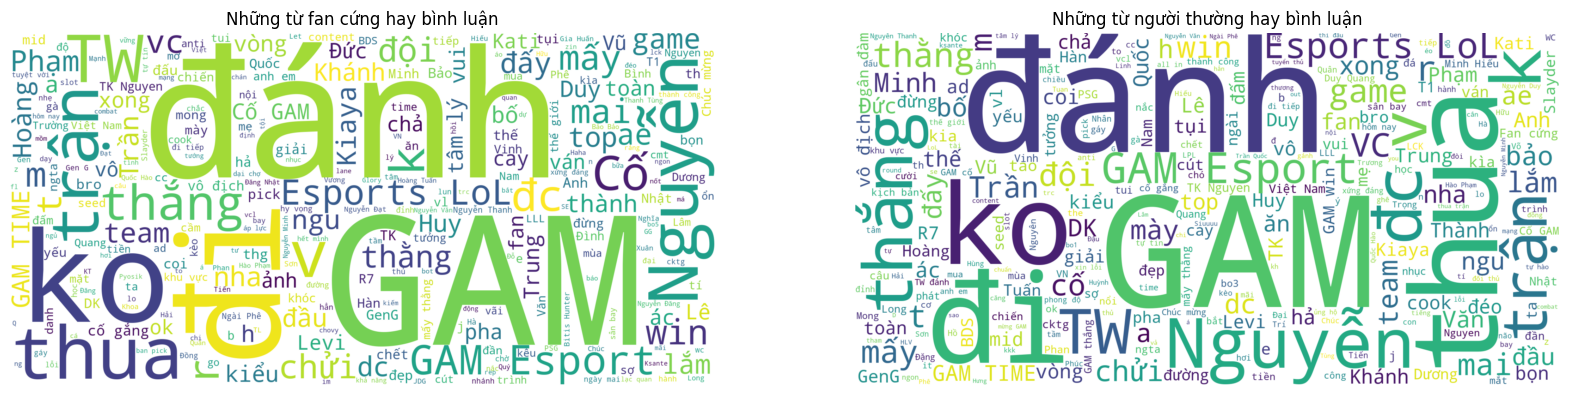

In [418]:
fan_lst, fan_text = handle_string(origin_cmt_df[origin_cmt_df['commenter_meta'] == "Fan cứng"], "comment_text")
nor_lst, nor_text = handle_string(origin_cmt_df[origin_cmt_df['commenter_meta'] == "Bình thường"], "comment_text")

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

wordcloud_fan = WordCloud(stopwords=stop_word,
                          background_color='white', 
                      max_words=300,
                      width=2000, height=1000
                         ).generate(fan_text)
wordcloud_nor= WordCloud(stopwords=stop_word,
                          background_color='white', 
                      max_words=300,
                      width=2000, height=1000
                         ).generate(nor_text)
ax[0].set_title("Những từ fan cứng hay bình luận")
ax[0].imshow(wordcloud_fan, interpolation='bilinear')
ax[1].set_title("Những từ người thường hay bình luận")
ax[1].imshow(wordcloud_nor, interpolation='bilinear')
ax[0].axis("off")
ax[1].axis("off")
plt.show()

### Tương quan giữa biểu cảm bình luận với số bình luận, độ dài text, số lượt shares, biểu cảm bình luận

In [419]:
sentiment_per_post = origin_cmt_df.groupby(['post_id', 'sentiment']).size().reset_index(name='count')
wide_format = sentiment_per_post.pivot_table(index='post_id', columns='sentiment', values='count', fill_value=0)
wide_format

sentiment        Negative  Neutral  Positive
post_id                                     
720151933484859       1.0      3.0       5.0
720564523443600      20.0     11.0      11.0
720637733436279       1.0      1.0       2.0
720681966765189       8.0     20.0      23.0
720729766760409      12.0     28.0      23.0
...                   ...      ...       ...
737427961757256       1.0      1.0       1.0
737500015083384      31.0     15.0       7.0
737886838378035       0.0      3.0       3.0
737919055041480       7.0      5.0       6.0
737976521702400       6.0      1.0       1.0

[192 rows x 3 columns]

In [420]:
reac_tbl = main_data[['post_id','thích', 'haha', 'yêu thích', 'buồn', 'thương thương', 'wow', 'phẫn nộ', 'shares', 'comments', 'reaction_count', 'post_text', 'date']]
reac_tbl['post_len'] = reac_tbl['post_text'].str.len()

sentiment_comment_tbl = pd.merge(wide_format,reac_tbl, on = "post_id", how = "left")
corr_tbl = sentiment_comment_tbl.drop(["post_id", "date", "post_text"], axis = 1)


C:\Users\Asus\AppData\Local\Temp\ipykernel_7100\2388200192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reac_tbl['post_len'] = reac_tbl['post_text'].str.len()


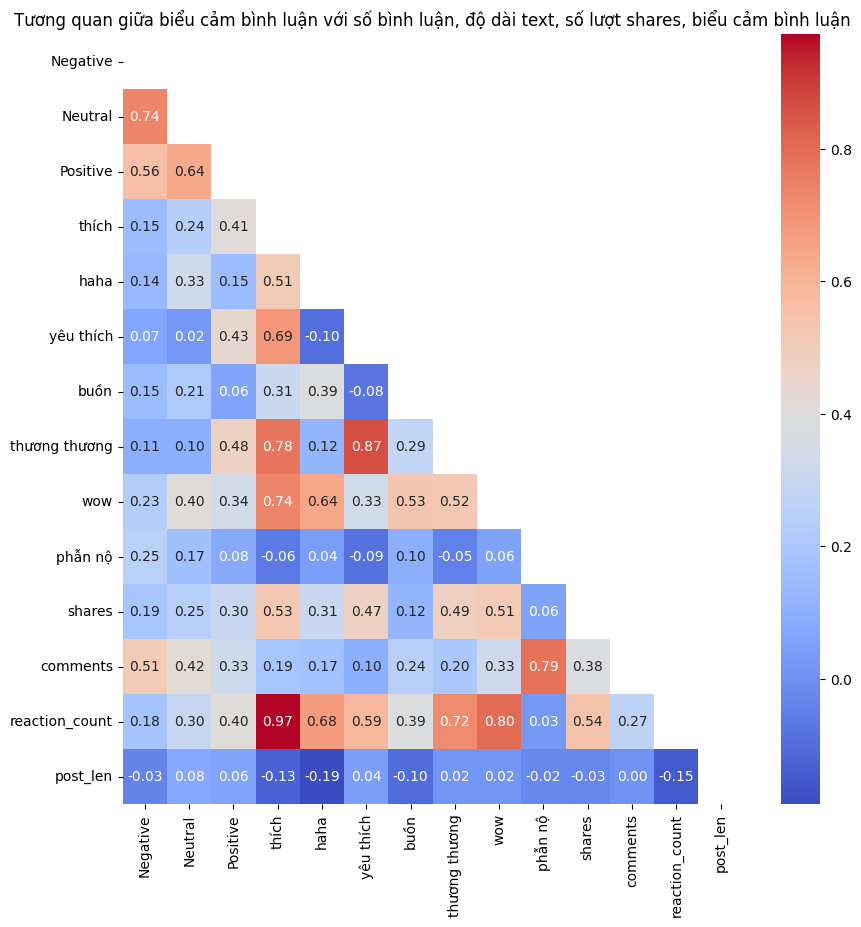

In [421]:
# corr_tbl = corr_tbl.drop("post_id", axis = 1)
corr_matrix = corr_tbl.corr()

plt.figure(figsize = (10, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_hm = sns.heatmap(mask = mask, data = corr_matrix, fmt=".2f", annot=True, cmap='coolwarm')
corr_hm.set_title("Tương quan giữa biểu cảm bình luận với số bình luận, độ dài text, số lượt shares, biểu cảm bình luận")
plt.show()

- Note : 
    - Lượt thích và số lượt reaction count có liên quan lớn với nhau => có thể thấy là do chủ yếu các bài viết đều có lượt thích lớn kéo theo tổng lượng comment tăng
    - Số lượng comment và phẫn nộ của bài viết liên quan tới nhau
    - post có chiều dài lớn thì lượng tương tác giảm

### 10 comment có tương tác cao

In [429]:
sentiment_reac_comment =  origin_cmt_df[origin_cmt_df['comment_reaction_count'] > 0].sort_values(by = "comment_reaction_count", ascending= False).head(20)
sentiment_reac_comment.groupby(sentiment_reac_comment['sentiment'])['comment_reaction_count'].count()

sentiment
Negative    11
Neutral      3
Positive     6
Name: comment_reaction_count, dtype: int64

## Phân tích điểm bất thường trên tập dữ liệu
- Ngày 20 - 10 và ngày 11 - 10 có lượng comment và phẫn nộ tăng đột biến
- Ngày 11 lượng bài đăng thấp, ngày 15 lượng bài đăng cao, ngày 21 - 22 lượng bài đăng thấp 

### Nội dung đăng vào ngày 10 - 11 - 20 - 21 - 22 

In [425]:
from datetime import datetime
date_conditions = ["2023-10-11", "2023-10-21", "2023-10-22", "2023-10-10", "2023-10-20", "2023-10-15", "2023-10-16", "2023-10-17", "2023-10-18"]
date_objects = [datetime.strptime(date_str, '%Y-%m-%d').date() for date_str in date_conditions]
sub_df = sentiment_comment_tbl[sentiment_comment_tbl['date'].isin(date_objects)]
sub_df = sub_df.sort_values("phẫn nộ", ascending= False)

In [426]:
sub_df['post_text'] = sub_df['post_text'].astype("string")
sub_df['post_text'] = sub_df['post_text'].apply(lambda x :re.sub(r'[^\w\s@/%._-]', '', x ))


sub_df['post_text'] = sub_df['post_text'].apply(lambda x : text_normalize(x))


In [427]:
sub_df.head(5)

post_id  Negative  Neutral  Positive   thích    haha  yêu thích  \
110  727596319407087      21.0     19.0      15.0  1561.0   704.0       20.0   
14   721287440037975      68.0     49.0      30.0  2411.0  1579.0       30.0   
15   721759033324149      32.0     25.0      16.0  1562.0   585.0       72.0   
13   721247613375291      30.0     21.0      17.0   900.0   447.0        8.0   
109  727584032741649      15.0      7.0      14.0  1423.0   107.0      121.0   

      buồn  thương thương   wow  phẫn nộ  shares  comments  reaction_count  \
110  177.0            8.0   7.0   2766.0      37      4286            5243   
14   264.0           16.0  11.0   1176.0      91      3532            5487   
15   102.0            6.0   3.0    949.0      14      1995            3279   
13    94.0            3.0   3.0    634.0      16      1368            2089   
109   29.0            9.0   0.0    456.0       3       817            2145   

                                             post_text       date  post_len  
110  GAM 0 - 1 FNC Sau thất bại này GAM sẽ phải hướ... 2023-10-20       161  
14   GAM 0 - 2 LLL GAM đã nhận thất bại đầu tiên tạ... 2023-10-10       126  
15   Một số hình ảnh của GAM sau ngày thi đấu đầu t... 2023-10-11        97  
13   GAM 0 - 1 LLL Một khởi đầu không thuận lợi cho... 2023-10-10        85  
109        Chiến thôi nào GAMTIME RiseAsOne Worlds2023 2023-10-20        52

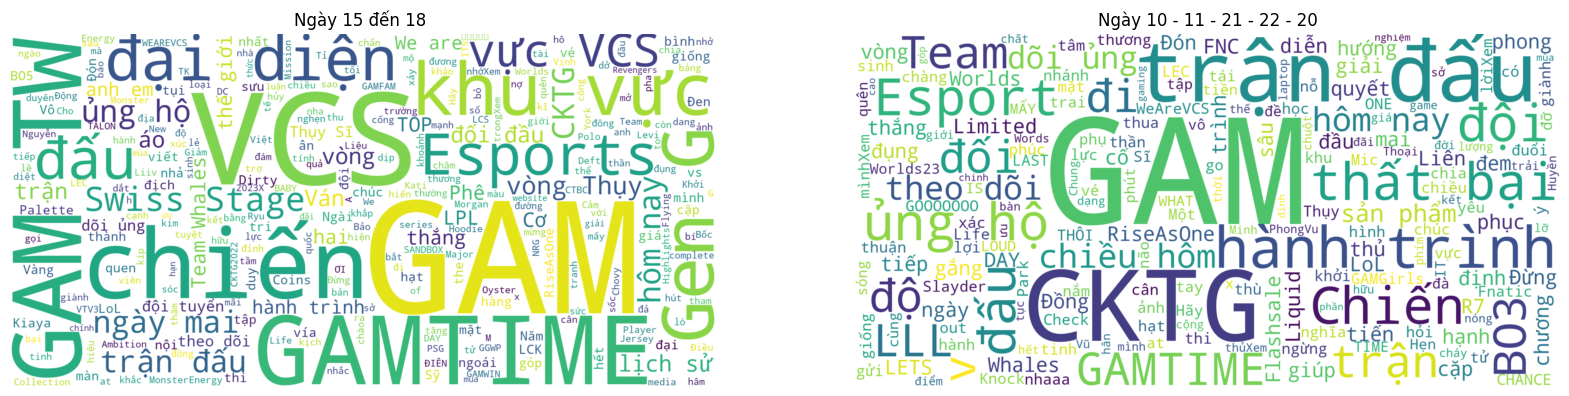

In [428]:


word_lst_max, text_max = handle_string(sub_df.loc[sub_df['date'].isin([datetime.strptime(date_str, '%Y-%m-%d').date() for date_str in ["2023-10-15", "2023-10-16", "2023-10-17", "2023-10-18"]])], "post_text")
word_lst_min, text_min = handle_string(sub_df.loc[~ sub_df['date'].isin([datetime.strptime(date_str, '%Y-%m-%d').date() for date_str in ["2023-10-15", "2023-10-16", "2023-10-17", "2023-10-18"]])], "post_text")

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

wordcloud_max = WordCloud(stopwords=stop_word,
                          background_color='white', 
                      max_words=300,
                      width=2000, height=1000
                         ).generate(text_max)
wordcloud_min= WordCloud(stopwords=stop_word,
                          background_color='white', 
                      max_words=300,
                      width=2000, height=1000
                         ).generate(text_min)
ax[0].set_title("Ngày 15 đến 18 ")
ax[0].imshow(wordcloud_max, interpolation='bilinear')
ax[1].set_title("Ngày 10 - 11 - 21 - 22 - 20")
ax[1].imshow(wordcloud_min, interpolation='bilinear')
ax[0].axis("off")
ax[1].axis("off")
plt.show()

In [ ]:
sub_tf_idf = find_tf_idf(word_lst_max, sub_df)
sub_sorted_items = sorted(sub_tf_idf.items(), key=lambda x: x[1], reverse=True)[:10]
for i in sub_sorted_items : 
    print (i)

('sản phẩm', 0.018644714045437685)
('Limited Flashsale', 0.01516021413203027)
('đem', 0.01516021413203027)
('diễn', 0.01516021413203027)
('đội', 0.011649797137866727)
('FNC', 0.010492556350481817)
('hướng', 0.010492556350481817)
('đụng độ', 0.010492556350481817)
('R7', 0.010492556350481817)
('cặp', 0.010492556350481817)
